<a href="https://colab.research.google.com/github/metamath1/ml-simple-works/blob/master/EM/em_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EM 알고리즘 완전분석 A Step by Step Introduction to EM Algorithm
---

2020.07.09 조준우(metamath@gmail.com)

# EM 알고리즘 - 1편





## 본 글의 목적

머신러닝을 공부하다 보면 한번은 보게되는 알고리즘이 바로 EM 알고리즘이다. 많은 문헌에서 이 알고리즘을 설명할 때 K-평균 군집화로 시작해서 가우시안 혼합으로 끝을 맺는다. 하지만 두 알고리즘에 대해서 설명하는 것은 EM 알고리즘의 적용 예를 설명하는 것이지 EM 알고리즘을 근본적으로 이해하기 위한 논리를 설명하는 것이 아니어서 해당 내용을 모두 읽어봐도 EM 알고리즘이 도대체 무엇인지 감을 잡기 힘든 경우가 대부분이다.

EM 알고리즘에 대해서 자세한 설명이 부족하게 된 원인은 개인적인 견해지만 EM 알고리즘이 확률과 통계를 기반으로 하는 알고리즘이기 때문이라 생각한다. 확률과 통계는 알아야 할 내용도 많고 매우 추상적이기 때문에 (적어도 나에게는) 기본적으로 쉽게 접근할 수 없는 문제가 있다. 그런데 그런 내용들이 복잡하게 얽혀 있다면 지면의 한계 또는 난이도의 제약으로 충분한 설명을 하지 못하는 것이 어쩌면 당연할 수도 있다는 생각이 든다.

이는 관련 분야 전공자들도 어느정도 인정하는 부분인데(https://bayestour.github.io/blog/2019/06/23/EM_algorithm.html) 이런 어려움은 정식으로 출판된 문헌에서도 확인할 수 있다. "The Elements of Statistical Learning"을 예로 들면 EM 알고리즘을 설명하는 8.5절에 뭉크의 절규 아이콘이 붙어 있다.
 
확률, 통계에 대한 초보적 지식을 가진 공대생이 참고할 만한 좋은 책은 "패턴인식과 머신러닝"(이하 PRML로 표기)인데 9장 전체를 할애하여 EM 알고리즘을 설명하고 있다. 그런데 이 교재 역시 내용을 전개하는 순서가 좋지 못해서 전체적인 맥락을 이해하기 매우 힘들다. 

이런 이유로 이 글은 PRML의 설명을 재구성하여 가능한 쉬운 예와 코드를 곁들여 EM 알고리즘을 이해하는 것을 목적으로 한다. 그렇기 때문에 수식 번호와 기호법은 PRML과 동일하게 구성하였다. 수식 번호에 (x.x)형식은 PRML 수식을 그대로 사용한 것이다. 혹시나 이 글을 읽고 PRML을 다시 읽을 때 혼란을 최소화 하기 위해서이다.

가급적 쉽게 설명하려고 많은 고민을 하였으나 기본적으로 이 글을 읽기 위한 선수 지식이 있음을 피할 수는 없었다. 이 글을 읽기 위한 선수 지식은 다음과 같다.

- 이항분포

- 가능도 함수

- 경사 하강법

- 최대 가능도 추정MLE:Maximum Likelihood Estimation

- 라그랑지 승수와 간단한 제약 최적화

- python 문법과 `scipy.optimize.minimize()` 함수 사용법

(선수 지식이 이 정도인데 이 글 정말 쉽게 이해할 수 있는 글 맞는건지?? ;;;)

## 기호

다음에 이 글 전반에 걸쳐 사용하는 기호를 정리하였다. 

- $x$, $\mathbf{x}$ : $D$차원 벡터인 데이터, 스칼라인 경우 $D=1$
- $N$ : 데이터 $\mathbf{x}$의 개수
- $N_k$ : $k$번째 분포에서 샘플링된 데이터 개수
- $\mathbf{X}$ : 데이터 $\mathbf{x}_n$이 행인 행렬. 차원은 `(N,D)`
- $K$ : 데이터를 샘플링한 분포의 개수
- $\mathbf{z}$ : $K$차원 벡터인 잠재변수, 이 잠재변수는 원핫인코딩된 다항변수이다.
- $\mathbf{Z}$ : 잠재변수 $\mathbf{z}_n$이 행인 행렬. 차원은 `(N,K)`
- $n_t$ : 이항분포에서 시도 횟수


## 문제 설정

본격적인 설명을 하기 앞서 EM알고리즘을 개략적으로 설명한 다음 글을 읽어보길 추천한다.

>"박준석, 2019, EM 알고리즘 이해 및 구현하기"(https://bayestour.github.io/blog/2019/06/23/EM_algorithm.html)

간단하게 문제를 설정하고 매우 직관적으로 EM알고리즘을 설명하는 좋은 글이다. EM 알고리즘에 대해 어느 정도 이해를 하고 있는 것 같은데 깔끔하게 정리가 안되는 느낌을 가지고 있다면 꼭 한번 읽어보길 추천한다.

본 글에서는 윗 글에서 다루고 있는 똑같은 사례에 좀 더 자세한 설명을 추가하는 것으로 논의를 시작하고자 한다. 박준석(2019)의 원문격에 해당하는 논문(https://www.nature.com/articles/nbt1406?proof=true) 에서는 베르누이 확률분포를 따르는 동전을 한 세트에 열번씩 다섯 세트 던지는 상황을 이야기 하고 있다. 이것을 박준석(2019)에서는 $n_t=10$인 이항분포에서 다섯 번 샘플링하는 방식으로 이야기하고 있다. 본 글에서도 후자를 기준으로 하며 그 문제는 다음과 같다.





> $\text{Bin}(x \mid n_t =10, \mu_1)$과 $\text{Bin}(x \mid n_t=10, \mu_2)$인 이항분포 두 개가 있다. 두 분포로 부터 독립적으로 다섯 번 샘플링을 하는데 (10, 4, 3, 7, 8)처럼 샘플링이 되었다. 이 정보를 가지고 $\mu_1$, $\mu_2$를 추정하시오.

이 상황을 코드로 구현하면 다음과 같다.

In [ ]:
# 글 전체에서 필요한 모듈을 임포트한다.
import numpy as np
import itertools

import matplotlib
import matplotlib.pyplot as plt

# 구글 코랩에서 그래프에 LaTeX를 원활히 쓰기 위한 설정으로 코랩이 아니면 실행 안함
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng > /dev/null



Extracting templates from packages: 100%


In [ ]:
# 두 이항분포의 알지 못하는 파라미터
MU_1, MU_2 = 0.8, 0.45

# 이항분포에서 시행횟수 n_t
n_t = 10

In [ ]:
# 샘플링
np.random.seed(1)

# 적당히 샘플링하고
x_from_p1 = np.random.binomial(n_t, MU_1, 3)
x_from_p2 = np.random.binomial(n_t, MU_2, 2)

# 섞어서 X를 만든다.
X = np.concatenate((x_from_p1, x_from_p2))
np.random.shuffle(X)

print(X)

[10  4  3  7  8]


여기서 우리가 하고자 하는 것은 데이터 (10, 4, 3, 7, 8)을 이용하여 두 분포의 파라미터 $\mu_1$과 $\mu_2$를 추정하는 것이다. 위 코드에서 $\mu_1=0.8$, $\mu_2=0.45$로 둔 것이 확인되지만 원래 이 숫자는 우리가 추정해야 하는 것이다.

만약 샘플 다섯 개가 분포 하나로 부터 나온 간단한 경우라면 분포의 파라미터를 추정하기 위해 데이터에 대한 최대 가능도 추정을 하면 된다. 하지만 샘플링하는 분포는 두 개이며 어느 분포에서 어떤 데이터가 샘플링되었는지 모르는 상황이다. 따라서 데이터에 대한 가능도 함숫값을 계산할 수 가 없다. 각 데이터가 어느 분포에서 샘플링되었는지 알고 있다면 각 분표별로 데이터를 나누고 각각 최대 가능도 추정을 하면 될것이다. 결국 위 상황에 대해서 모든 정보를 다 알고 있다고 말할 수 있으려면 샘플링된 숫자 다섯 개가 어느 분포에서 샘플링되었는지도 알아야 한다. 



샘플링된 데이터를 $x_n$으로 쓰기로 하자. 그리고 $x_n$이 어느 분포에서 생성되었는지를 나타내는 카테고리 변수를 $\mathbf{z}_n$으로 쓰기로 하자. 앞서 말한 것처럼 모든 정보를 다 알고 있다고 하려면 $x_1$, $x_2$, $x_3$, $x_4$, $x_5$와 이에 해당하는  $\mathbf{z}_1$, $\mathbf{z}_2$, $\mathbf{z}_3$, $\mathbf{z}_4$, $\mathbf{z}_5$도 모두 알아야 한다. 우리가 가진 데이터가 1번 분포, 2번 분포, 2번 분포, 1번 분포, 1번 분포에서 생성되었다면 $\mathbf{z}_n$은 각각 다음과 같을 것이다.

$$
\mathbf{z}_1 = (1, 0)^\text{T} \\
\mathbf{z}_2 = (0, 1)^\text{T} \\
\mathbf{z}_3 = (0, 1)^\text{T} \\
\mathbf{z}_4 = (1, 0)^\text{T} \\
\mathbf{z}_5 = (1, 0)^\text{T} 
$$

이제 $x_n$, $\mathbf{z}_n$을 모두 모아 행렬 $\mathbf{X}$, $\mathbf{Z}$로 표기하자. 행렬 $\mathbf{X}$에서 한 행은 $x_n$인데 만약 샘플링되는 데이터가 벡터라면 $\mathbf{x}_n^{\text{T}}$가 될 것이다. 행렬 $\mathbf{Z}$에서 한 행은 $\mathbf{z}_n^{\text{T}}$이다. 행렬 $\mathbf{X}$와 $\mathbf{Z}$는 다음과 같게 된다.

$$
\mathbf{X} = \begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5
\end{bmatrix}= \begin{bmatrix}
10\\ 4\\ 3\\ 7\\ 8
\end{bmatrix} \qquad
\mathbf{Z} = \begin{bmatrix}
\mathbf{z}_1^{\text{T}} \\
\mathbf{z}_2^{\text{T}} \\
\mathbf{z}_3^{\text{T}} \\
\mathbf{z}_4^{\text{T}} \\
\mathbf{z}_5^{\text{T}}
\end{bmatrix}=\begin{bmatrix}
1 & 0 \\ 0 & 1 \\ 0 & 1 \\ 1 & 0 \\ 1 & 0
\end{bmatrix}
$$

간단하게 아래 코드로 행렬 $\mathbf{X}$, $\mathbf{Z}$를 만들어 두자.

In [ ]:
# X: (N,D), (5,1)
X = X.reshape(-1,1)
print(X)

# Z: (N,K), (5,2)
Z = np.array([[1,0],[0,1],[0,1],[1,0],[1,0]])
print(Z)

# 노트북 전체에 사용될 전역 변수 설정
N, D = X.shape
K = 2

[[10]
 [ 4]
 [ 3]
 [ 7]
 [ 8]]
[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]]


이렇게 두 행렬 $\{\mathbf{X}, \mathbf{Z}\}$가 모두 주어지는 데이터를 완전 데이터 세트complete data set라 한다. 완전 데이터 세트일 때 최대 가능도 추정을 실제로 해보자.




## 완전 데이터 세트에 대한 최대 가능도 추정



### 가능도 함수

문제 설정에서 주어진 문제는 확률분포가 2개인 경우지만 $K$개로 가정하고 이야기하자. 주어진 $K$개 분포중 특정 $k$번째 분포가 선택될 확률을 $\pi_k$로 표시하자. 그러면 어떤 샘플 $x$에 대한 확률질량함수는 다음처럼 주어진 확률분포함수를 선형조합하여 얻을 수 있을 것이다. 이때 선형조합 계수는 $\pi_k$가 될 것이다.

$$
p(x)  = \sum_{k=1}^K \pi_k \text{Bin}(x \mid n_t, \mu_k) \tag{9.7}
$$

직관적으로 식(9.7)이 맞을 것 같지만 정말 그렇게 되는지는 불완전 데이터 세트에 대한 가능도 함수를 구할 때 다시 정식으로 유도해보자.

앞서 살펴봤듯이 $x$가 어떤 분포에서 샘플링 되었는지를 나타내는 잠재변수latent variable $\mathbf{z}$는 $K$차원 멀티누이multinoulli 변수이다. 따라서 변수 $\mathbf{z}$의 확률질량함수는 식(9.10)처럼 쓸 수 있다.

$$
p(\mathbf{z}) = \prod_{k=1}^{K} \pi_k^{z_k} \tag{9.10}
$$

$\mathbf{z}$가 주어졌다면 샘플 $x$가 어느 분포를 따르는지 알 수 있으므로 해당 샘플의 확률분포 함수는 그 $\mathbf{z}$가 가리키는 분포의 $\text{Bin}(x \mid n_t, \mu_k)$가 된다. 다시말해 $\mathbf{z}$가 주어진 조건하에서 $x$의 확률분포 함수는 식(9.11)처럼 결정되게 된다.

$$
p(x \mid \mathbf{z}) = \prod_{k=1}^K \text{Bin}(x \mid n_t, \mu_k)^{z_k} \tag{9.11}
$$

$\mathbf{z}$에서 $z_k$는 오직 하나만 1이고 나머지는 0이므로 잘 생각해보면 식(9.11)이 타당함을 알 수 있다. 이제 $x$와 $\mathbf{z}$의 결합확률분포를 생각하자.

$$
p(x,\mathbf{z}) = p(x \mid \mathbf{z})p(\mathbf{z}) = \prod_{k=1}^K \pi_k^{z_k} \text{Bin}(x \mid n_t, \mu_k)^{z_k} 
$$

파라미터를  $\boldsymbol{\theta}=(\pi_1, \pi_2, ..., \pi_k, \mu_1, \mu_2, ..., \mu_k)^{\text{T}}$로 쓰면 완전 데이터 세트의 $\boldsymbol{\theta}$에 대한 가능도 함수는 다음과 같다.

$$
p(x,\mathbf{z} \mid \boldsymbol{\theta}) = \prod_{k=1}^K \pi_k^{z_k} \text{Bin}(x \mid n_t, \mu_k)^{z_k} 
$$

모든 데이터를 고려하기 위해 데이터에 대한 인덱스 $n$을 도입하고 독립성 가정하에서 가능도를 구하기 위해 모두 곱해주자.

$$
p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta}) = \prod_{n=1}^N \prod_{k=1}^K \pi_k^{z_{nk}} \text{Bin}(x_n \mid n_t, \mu_k)^{z_{nk}} 
$$

 이제 가능도 함수에 로그를 적용하면 최종적으로 완전 데이터 세트에서 로그 가능도 함수가 구해진다.

$$
\ln p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta}) = \sum_{n=1}^N \sum_{k=1}^K z_{nk} \{ \ln \pi_k + \ln \text{Bin}(x_n \mid  n_t, \mu_k) \} \tag{9.36}
$$

식(9.36)에서 $z_{nk}$를 모두 알고 있으므로 로그 가능도함수의 함숫값을 실제로 구할 수 있고 이를 이용하여 수지척으로 식(9.36)을 최적화 할 수 있다.


### 수치적 방법

가능도 함수를 구했으므로 이 가능도 함수를 기울기 하강법을 이용하여 직접 최적화 시켜볼 수 있다.

In [ ]:
from scipy.stats import binom
from scipy.optimize import minimize, Bounds

식(9.36)을 목적함수로 설정하고 나머지 최적화 과정은 사이파이 최적화 함수를 쓰기로 하자. 위처럼 필요한 모듈을 임포트 한다. 결정해야하는 변수는 $\mu_1$, $\mu_2$, $\pi_1$, $\pi_2$이고 초기값은 적당히 초기화 한다.



In [ ]:
# 초기 파라미터를 주어진 데이터 중에서 아무거나 골라 만든다.
np.random.seed(34)

mu_0 = X[np.random.choice(N, K)] / n_t

# pi는 동일하게 설정한다.
pi_0 = np.array([0.5, 0.5])

print(mu_0)
print(pi_0)

[[0.4]
 [0.3]]
[0.5 0.5]


이제 식(9.36)을 그대로 코딩한다.

In [ ]:
def loglikelihood_XZ_(mu, pi, X, Z):
    """
    eq(9.36)
    mu     : (K,D)
    pi     : (K,)
    X      : (N,D) global variable
    Z      : (N,K)
    -----------------------------------------
    N,D,K : gloval variables
    """
    # N, D, K = X.shape[0], X.shape[1], Z.shape[1]
    
    sigma_n = 0.0
    
    for n in range(N):
        sigma_k = 0.0
        
        for k in range(K):
            loglikelihood_x = np.log(binom.pmf(X[n,0], n_t, mu[k,0])+1.0e-8)
            sigma_k += Z[n,k] * (np.log(pi[k]+1.0e-8) + loglikelihood_x)
            
        sigma_n += sigma_k
        
    return sigma_n

`scipy.optimize.minimize()`함수를 사용하기 위해서는 최적화 변수가 1차원 벡터 형식으로 전달되어야 한다. 위 `loglikelihood_XZ_()`함수는 $\mu_k$와 $\pi_k$를 `(K,D)`, `(K,)` 형태로 전달받으므로 `minimize()`함수에 바로 사용할 수 없다. 그래서 $\mu_k$와 $\pi_k$ 한 줄로 펴서 벡터 형태로 만든 다음 전달할 래퍼함수를 하나 더 만든다.

In [ ]:
def loglikelihood_XZ(theta, X, Z):
    """
    theta[:K*D] : mu, (K,D)   
    theta[K*D:] : pi, (K,)    
    X           : (N,D)
    Z           : (N,K)
    -----------------------------------
    N,D,K : gloval variables
    """
    
    # N, D, K = X.shape[0], X.shape[1], Z.shape[1]
    
    mu = theta[:K*D].reshape(K,D)
    pi = theta[-K:]
    
    return loglikelihood_XZ_(mu, pi, X, Z)


위 함수는 모든 $\mu_k$와 $\pi_k$를 담은 1차원 벡터 `theta`를 전달 받는다. 그 후 적당히 `theta`를 분리하고 `loglikehood_XZ_()`함수에 전달하고 있다.

앞서 정의한 두 함수가 같은 값을 계산하는지 확인해본다. 같은 값이 나오면 최종적으로 음수를 곱해서 NLL(Negative Log Likelihood)로 만든다. 사이파이에서 제공하는 `minimize()`함수는 최소화를 수행하기 때문이다.

In [ ]:
# 래퍼함수와 원함수 결과가 같게 나오는지 확인
theta = np.hstack((mu_0.flatten(),  pi_0))
print(loglikelihood_XZ_(mu_0, pi_0, X, Z))
print(loglikelihood_XZ(theta, X, Z))

# 로그 가능도 함수의 최대화를 마이너스 로그 가능도함수의 최소화로 바꾸기 위해
# 보조 함수 정의
def negative_loglikelihood_XZ(theta, X, Z):
    return -loglikelihood_XZ(theta, X, Z)

-23.26286598620995
-23.26286598620995


이제 각 변수에 대해서 적당히 바운드 제약조건을 설정한다.  각 파라미터에 대해 $0 \le \pi_k, \mu_k \le 1$가 보장되어야 할것이다.

In [ ]:
# 바운드 제약조건
bounds = Bounds((0., 0.,   # mu_k의 하한
                 0., 0),   # pi_k의 하한
                (1., 1.,   # mu_k의 상한 
                 1., 1.))  # pi_k의 상한

$\pi_k$는 멀티누이 변수 $\mathbf{z}$의 파라미터이기 때문에 모두 더해서 1이 되어야 하므로 다음처럼 제약조건을 추가한다.


$$
\sum_{k=1}^K \pi_k = 1
$$

In [ ]:
# 등호제약조건, p(z)에 대한 제약조건 다 더해서 1
# sum pi = 1
def constraint(theta):
    pi = theta[-K:]
    return pi.sum() - 1.

cons   = ( {'type': 'eq',   'fun': constraint   }, )

이제 목적함수와 제약조건을 `minimize()`함수에 넘기면 최적화 과정이 수행된다.

In [ ]:
# 각 파라미터를 펼쳐서 1차원 배열 하나로 만든다.
theta = np.hstack((mu_0.flatten(), pi_0))
x = np.copy(theta)
print('Init. input:', x)

res = minimize(negative_loglikelihood_XZ, x, args=(X, Z), method='slsqp', 
               bounds=bounds, constraints=cons,
               options={'iprint': 2, 'disp': True})

print(res)

print("sum pi_k:",res.x[2:].sum())

Init. input: [0.4 0.3 0.5 0.5]
  NIT    FC           OBJFUN            GNORM
    1     6     2.326287E+01     5.484928E+01
    2    13     1.895467E+01     4.216554E+01
    3    20     1.694546E+01     3.614093E+01
    4    27     1.525500E+01     3.100563E+01
    5    34     1.433698E+01     2.762727E+01
    6    41     1.327568E+01     2.376365E+01
    7    47     1.170940E+01     2.275331E+01
    8    53     1.132655E+01     1.118621E+01
    9    59     1.112874E+01     7.772592E+00
   10    65     1.110341E+01     7.117206E+00
   11    71     1.110208E+01     7.069603E+00
   12    77     1.110207E+01     7.071547E+00
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 11.102073936079918
            Iterations: 12
            Function evaluations: 77
            Gradient evaluations: 12
     fun: 11.102073936079918
     jac: array([-3.89838219e-03,  4.10699844e-03, -4.99865413e+00, -5.00201964e+00])
 message: 'Optimization terminated successful

몇 회 반복 후 다음처럼 해를 찾게 된다.

`x: array([0.83331527, 0.35004671, 0.60016153, 0.39983847])`

수치적으로 찾은 해는 

$$
\mu_1 = 0.83331527, \quad \mu_2=0.35004671, \quad \pi_1=0.60016153, \quad \pi_2=0.39983847
$$

이며 출력 마지막 줄 `sum pi_k: 1.0`를 보면 $\pi_k$에 대한 제약조건도 잘 지켜지고 있음을 알 수 있다. 사실 이 정도 문제는 가능도 함수가 복잡하지 않아서 직접 미분하여 해석적으로 최대 가능도 해를 구할 수 있다. 



### 해석적 방법

가능도 함수를 직접 미분하여 최적해를 바로 찾아보자. 식(9.36)을 $\mu_j$와 $\pi_j$로 미분한다.

$$
\begin{aligned}
\frac{\partial}{\partial \mu_j} \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) 
&= \frac{\partial}{\partial \mu_j} \sum_{n=1}^N \sum_{k=1}^K z_{nk} \{ \ln \pi_k + \ln \text{Bin}(x_n \mid  n_t, \mu_k) \} \\
&= \sum_{n=1}^N \sum_{k=1}^K z_{nk}  \left\{ \frac{\partial}{\partial \mu_j} \ln \pi_k +  \frac{\partial}{\partial \mu_j} \ln \text{Bin}(x_n \mid  n_t, \mu_k)  \right\} \\
&= \sum_{n=1}^N \sum_{k=1}^K z_{nk} \left[ \frac{\partial}{\partial \mu_j}  \left\{ \ln \begin{pmatrix} n_t \\ x_n \end{pmatrix} \mu_k^{x_n} (1-\mu_k)^{(n_t - x_n)} \right\} \right] \\
&= \sum_{n=1}^N \sum_{k=1}^K z_{nk} \left[ \frac{\partial}{\partial \mu_j}  \left\{ \ln \begin{pmatrix} n_t \\ x_n \end{pmatrix} + {x_n} \ln \mu_k + {(n_t - x_n)} \ln  (1-\mu_k) \right\} \right]
\end{aligned}
$$


위 과정에서 세 번째 등호는 $\ln \pi_k$가 $\mu_j$의 함수가 아니므로 성립한다. 마지막 줄에서 $\{ \}$안을 미분하면 $k=j$인 경우를 제외하고는 모두 0이 된다. $\{ \}$안 첫째 항은 $\mu_j$에 대해서 상수라서 사라지고 둘째항과 셋째항을 미분하면 아래와 같다.

$$
\begin{aligned}
\frac{\partial}{\partial \mu_j} \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) &= \sum_{n=1}^N z_{nj} \left( \frac{x_n}{\mu_j} - \frac{n_t - x_n}{1-\mu_j} \right) \\
&= \sum_{n=1}^N z_{nj} \left( \frac{x_n - n_t \mu_j}{\mu_j (1-\mu_j)} \right)
\end{aligned}
$$

마지막 식을 0으로 두고 정리한다.

$$
\sum_{n=1}^N z_{nj} \left( \frac{x_n - n_t \mu_j}{\mu_j (1-\mu_j)} \right)=0 
$$

인덱스 $n$에 관계없는 항을 합산 기호 밖으로 뽑아낸다.

$$
\frac{1}{\mu_j (1-\mu_j)} \sum_{n=1}^N z_{nj} \left(x_n - n_t \mu_j \right) = 0
$$

그러면 합산 기호에 의한 항이 0이 되어야 하므로 

$$
\sum_{n=1}^N z_{nj} \left(x_n - n_t \mu_j \right) = 0 
$$

합산 기호를 분배하고

$$
\sum_{n=1}^N z_{nj} x_n - \sum_{n=1}^N z_{nj} n_t \mu_j = 0 
$$

이항한다.

$$
n_t \mu_j \sum_{n=1}^N z_{nj} = \sum_{n=1}^N z_{nj} x_n 
$$

좌변에 $\mu_j$만 남기고 우변으로 넘기면 

$$
\mu_j = \frac{\sum_{n=1}^N z_{nj} x_n }{n_t \sum_{n=1}^N z_{nj} }
$$

위 식에서 $ \sum_{n=1}^N z_{nj}=N_j$이므로 최종적으로 


$$
\mu_j= \frac{\sum_{n=1}^N z_{nj} x_n}{n_t N_j} \tag{1}
$$

구해진 식(1)은 $j$번째 분포를 따르는 샘플들의 평균으로 완전 데이터 세트에 대한 최대 가능도 해가 구해짐을 말해준다. 







이제 $\pi_j$에 대해서 미분하여 같은 과정을 반복한다. 단 이 때는 수치적 방법에서와 마찬가지로 $\pi_k$를 모두 더해서 1이 되어야 한다는 제약조건을 고려해야한다.

$$
\sum_{k=1}^K \pi_k = 1
$$

물론 $\mu_k$에도 $ 0 \le \mu_k \le 1$라는 제약조건이 있지만 미분할 때 반영하지 않은 이유(http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A19/ 에 lecture 4 참고)
는 제약 없이 구해진 해가 제약조건을 만족시키기 때문이다. 식(1)을 보면 구해진 최종해가 $\mu_j \in [0,1]$임을 알 수 있다. 

$\pi_j$로 미분하는 과정은 이렇게 제약조건을 반영해야해서 조금 번거롭지만 그리 복잡하진 않기 때문에 직접 해보기로 하자. 라그랑지 승수lagrange multiplier $\lambda$를 도입하고 라그랑지안lagrangian을 구성하자.

$$
\mathcal{L}(\boldsymbol{\theta}, \lambda)= \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) + \lambda \left( \sum_{i=1}^K \pi_i -1 \right) \tag{2}
$$

식(2)를 $\pi_j$에 대해서 미분하는 과정은 다음과 같다.

$$
\begin{aligned}
 \frac{\partial}{\partial \pi_j} & \left\{ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) + \lambda \left( \sum_{i=1}^K \pi_i -1 \right) \right\} \\
&= \frac{\partial}{\partial \pi_j} \left[  \sum_{n=1}^N \sum_{k=1}^K z_{nk} \{ \ln \pi_k + \ln \text{Bin}(x_n \mid  n_t, \mu_k) \}  + \lambda \left( \sum_{i=1}^K \pi_i -1 \right) \right] \\
&= \sum_{n=1}^N \sum_{k=1}^K    z_{nk} \left\{\frac{\partial}{\partial \pi_j} \ln \pi_k + \frac{\partial}{\partial \pi_j} \ln \text{Bin}(x_n \mid  n_t, \mu_k) \right\}  + \lambda \left(  \sum_{k=1}^K  \frac{\partial}{\partial \pi_j}(\pi_i -1) \right) \\
&= \sum_{n}^N \left(  \frac{z_{nj}}{\pi_j}\right) + \lambda
\end{aligned} \tag{3}
$$

식(2)를 $\lambda$에 대해 미분하면 다음과 같다.

$$
\frac{\partial}{\partial \lambda} \left\{ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) + \lambda \left( \sum_{i=1}^K \pi_i -1 \right) \right\} =\sum_{i=1}^K \pi_i -1 \tag{4}
$$

이제 식(3),(4)를 모두 0으로 두고 연립방정식을 풀어서 해를 구한다.

$$
\sum_{n}^N \left(  \frac{z_{nj}}{\pi_j}\right) + \lambda = 0 \tag{5}
$$

$$
\sum_{j=1}^K \pi_j -1 = 0 \tag{6}
$$

식(5)으로 부터 

$$
\pi_j = -\frac{N_j}{\lambda} \tag{7}
$$

을 얻고 식(7)을 식(6)에 대입하면 $\lambda = -N$을 구할 수 있다. 따라서 최종적으로 

$$
\pi_j = \frac{N_j}{N} \tag{8}
$$


완전 데이터 세트에 대한 최대 가능도 추정은 식(1)과 식(8)로 주어진다. 확률분포에 대한 인덱스를 일관적으로 사용하기 위해 인덱스를 $k$로 바꾸고 다시 적으면 다음과 같다.

$$
\mu_k= \frac{\sum_{n=1}^N z_{nk} x_n}{n_t N_k} \tag{9}
$$

$$
\pi_k = \frac{N_k}{N} \tag{10}
$$


식(9), (10)은 최대 가능도 추정을 통해 구해진 분포의 파라미터 $\mu_k$는 $k$번 째 분포를 따르는 샘플들의 평균이며 혼합계수 $\pi_k$는 간단히 분포를 따르는 샘플들의 비가 됨을 알려준다.

이 결과를 주어진 데이터에 적용해보면 10, 7, 8은 $\text{Bin}(x \mid n_t = 10, \mu_1)$로 부터 나온 데이터이므로 식(9)에 의해

$$
\mu_1 = \frac{10+7+8}{10 \times 3}=\frac{25}{30}= 0.833333
$$

4, 3은 $\text{Bin}(x \mid n_t=10, \mu_2)$로 부터 나온 데이터이므로

$$
\mu_2 = \frac{4+3}{10 \times 2}=\frac{7}{20}= 0.35
$$

이 된다. 혼합계수에 대해서는 식(10)에 의해
해
$$
\pi_1 = \frac{3}{5}=0.6, \qquad \pi_2 = \frac{2}{5}=0.4
$$

로 완전 데이터 세트의 최대 가능도 해를 구할 수 있다. 수치적으로 구한 해와 거의 같은 해가 구해지는 것을 확인할 수 있다.


지금까지 과정을 통해 완전 데이터 세트에 대해서는 가능도 함수를 최대화 시키는 방식으로 비교적 간단하게 파라미터를 추정할 수 있다는 사실을 알았다. 하지만 문제는 우리에게 행렬 $\mathbf{Z}$에 대한 정보가 전혀 없다는 것이다. 다시말해 우리에게 주어진 데이터는 불완전 데이터 세트incomplete data set이다.

## 모르는 데이터를 어떻게 할 것인가?

### 평균이란?

이쯤에서 잠시 머리를 식힐겸 평균에 대해서 이야기해보자. 우리는 주어진 데이터를 정리하는 개념으로 평균을 인식하는 경우가 많다. 예를 들어 10명인 반의 시험 점수 10개를 다 들여다보기 보다 평균점만 보고 그 반의 성적을 대강 짐작하는 식으로 평균을 사용하게 된다. 하지만 평균은 우리가 알고 싶은 숫자를 잘 모를 때 사용할 수도 있다. 비슷한 수준의 학생이 입학한다고 했을 때 열한 번째 학생의 성적을 모르지만 앞서 구해놓은 평균으로 예측해볼 수 있다는 것이다.

예를 들어보자. 당신은 프로야구팀 감독이며 팀 성적이 좋아서 한국시리즈까지 진출했다. 내일 1차전이 열리는데 우리팀의 승률을 알고 싶다고 하자. 우리팀의 승률은 상대팀의 선발투수에 따라서 달라지는 것이 당연할 것이다. 수석코치에게 물어보니 시즌 전적을 바탕으로 볼 때 1선발이 등판하면 우리팀 승률은 0.45, 2선발이 등판하면 0.6이라고 한다. 모종의 이유로 1차전에 1선발이 등판할지 2선발이 등판할지 예측할 수 없다면 수석코치는 감독에게 1차전 승률을 어떻게 보고해야할까? 대부분 사람들이 당연하다는 듯이 다음처럼 평균을 구할 것이다.

$$
\frac{0.45+0.6}{2}=0.525 \tag{11}
$$

위 식은 1선발과 2선발이 등판할 확률을 모르기 때문에 같다고 임의로 결정한 결과이다. 그런데 만약 1선발이 등판할 확률이 80%라면 예측이 좀 달라져야하지 않을까?

$$
0.8 \times 0.45 + 0.2 \times 0.6 = 0.48 \tag{12}
$$

즉 시합 열 번중에 여덟 번은 1선발이 등판하고 두 번은 2선발이 등판한다고 했을 때 평균을 구한 것이다. 만약 상대팀이 선발등판 예고를 2선발로 했다면 더 볼 것도 없이 승률은 0.6이 된다.

$$
0 \times 0.45 + 1 \times 0.6 = 0.6 \tag{13}
$$

지금 우리가 무엇을 하고 있는지 생각해보자. 

상대팀의 선발투수 등판 상태 상태에는 1선발이 나오거나 2선발이 나오거나 두가지 상태가 있다. 다만 이 두 가지 중 어떤 상태로 결정될지는 알 수 없다. 대신 각 상태에 대한 확률을 '모두' 알고 있다면 모든 상태에 대해서 평균을 계산하여 내일 승률을 예측할 수 있는 것이다. 식(11)에서는 각 상태에 50%씩 확률을 할당한 경우, 식(12)는 1선발이 등판하는 상태1에 80%, 2선발이 등판하는 상태2에 20%를 할당한 경우, 식(13)은 상태1에 0%, 상태2에 100%를 할당한 경우에 승률을 계산한 것이다.

이렇게 알 수 없는 정보가 있는데 그 정보가 가질 수 있는 모든 상태에 대해서 확률을 할당할 수 있다면 평균을 구해서 모르는 부분을 채울 수 있는 것이다.


### 전체적인 전략

우리는 $\mathbf{Z}$가 어떤 모양인지 모른다. 여기서 앞선 논의를 적용해보자.

1. $\mathbf{Z}$를 모르기 때문에 $\mathbf{Z}$가 가능한 모든 상태를 생각해보자.
2. 그리고 그 상태들에 확률을 부여할 수 있다고 가정해보자. 
3. 그러면 모든 상태에 대해서 가능도 함숫값을 구하고 그렇게 구해진 함숫값들을 해당 $\mathbf{Z}$에 부여된 확률을 이용해서 평균낼 수 있지 않을까? 
4. 그렇게만 할 수 있다면 그 가능도 함숫값의 평균을 최대화하는 파라미터를 찾을 수 있을 것이다.

마지막 4번 문장에서 평균을 기댓값이란 용어로 바꿔보자. 

>"그렇게만 할 수 있다면 그 가능도 함숫값의 **기댓값을 최대화**하는 파라미터를 찾을 수 있을 것이다." 

우리가 알고 싶어하는 기댓값 최대화라는 이슈가 등장한 것이다!

다시 정리하자. 우리에게 완전 데이터 세트가 주어져 있다면 데이터의 파라미터에 대한 가능도 함숫값을 계산할 수 있고 이를 통해 최대화를 수행할 수 있다. 하지만 불완전 데이터 세트가 주어졌기 때문에 가능도 함숫값을 계산할 수 없다. 대신 모르는 데이터에 대해서 가능한 모든 상태를 상정하고 가능도 함숫값을 구해 그것들의 평균을 계산한다. 이 평균을 최대화 해보자는 것이다.

현재 설정된 문제에서 가능한 $\mathbf{Z}$는 모두 $2^5=32$가지가 있다. 이제 우리에게 주어진 첫 번째 과제는 존재 가능한 모든 $\mathbf{Z}$에 대해서 확률을 부여하는 것이다.

# EM 알고리즘 - 2편

사실 지난 편을 통해 EM 알고리즘의 가장 핵심적인 사항을 모두 이야기하였다. 모든 데이터를 알고 있을 때 계산할 수 있는 가능도 함숫값의 기대값을 최대화 하는 것이 핵심이다. 여기서 문제는 가능도 함숫값을 구할 수 없는데 그 평균은 구할 수 있다고 하는 부분이다. 언뜻 생각해서는 이게 가능한가 싶은 생각이 든다. 여기에 대해서 구체적으로 이야기 하기 전에 불완전 데이터 세트에 대한 가능도 함수를 직접 구성해서 문제를 해결해보도록 하자. 이 과정을 통해 평균을 최대화 시키는 방법에 대한 부가적인 이유도 짐작해볼 수 있게 된다.

## 불완전 데이터 세트에 대한 최대 가능도 추정

### 가능도 함수

현재 주어진 데이터 세트가 불완전 데이터 세트라면 $\ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})$를 구할 수 없기 때문에 $\mathbf{z}$를 주변화 시켜 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 직접구하는 전략을 써볼 수 있다. 주어진 $\mathbf{X}$를 가장 잘 발생시킬것 같은 $\boldsymbol{\theta}$를 찾는 것이 최대 가능도 추정이므로 궁극적으로는 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 최대화 시키고 싶은 것이다. 

앞서 직관적인 방법으로 식(9.7)로 $p(x)$를 정의했었는데 여기서 정식으로 유도해보도록 하자. 우선 식(9.10)은 멀티누이 변수의 확률질량함수이므로 그 자체로 타당하다. 

$$
p(\mathbf{z}) = \prod_{k=1}^{K} \pi_k^{z_k} \tag{9.10}
$$

다음으로 어떤 확률분포인지 알려주는 $\mathbf{z}$가 주어졌다면 $x$에 대한 확률분포는 주어진 이항분포 $K$개중 하나가 되므로 식(9.11)도 어렵지 않게 이해할 수 있다.

$$
p(x \mid \mathbf{z}) = \prod_{k=1}^K \text{Bin}(x \mid n_t, \mu_k)^{z_k} \tag{9.11}
$$

확률의 곱법칙에 의해 $p(x,\mathbf{z})=p(\mathbf{z})p(x \mid \mathbf{z})$이므로 다음이 성립하고

$$
p(x,\mathbf{z}) = \prod_{k=1}^K \pi_k^{z_k} \text{Bin}(x \mid n_t, \mu_k)^{z_k} 
$$

이를 확률의 합법칙에 의해 $\mathbf{z}$에 대해서 주변화 하면 $p(x)$를 얻을 수 있다.

$$
p(x) = \sum_{\mathbf{z}}  \prod_{k=1}^K \pi_k^{z_k} \text{Bin}(x \mid n_t, \mu_k)^{z_k} 
$$

위 식에서 $\prod$에 의해 곱해지는 항 $K$개는 $z_k$가 오직 하나만 1이고 나머지는 다 0인 상태이다. 따라서 한 개 항만 살아남는다. 그런 항 $K$개를 모든 $\mathbf{z}$에 대해서 다 더하고 있으므로 결과적으로는 $K$개 항만 더해지는 것으로 다음처럼 정리된다.

$$
p(x) = \sum_{\mathbf{z}}  \prod_{k=1}^K \pi_k^{z_k} \text{Bin}(x \mid n_t, \mu_k)^{z_k} = \sum_{i=1}^K \pi_k \text{Bin}(x \mid n_t, \mu_k) \tag{9.12}
$$

직관적으로 정의 했던 식(9.7)을 다시 얻을 수 있다. 굳이 힘들게 $p(x)$를 유도한 이유는 유도 과정에서 $\mathbf{z}$를 주변화해야만 하고 그로 인해 최종 식에 $\sum_{k}$가 등장한다는 것을 보이기 위함이다. 식(9.12)에서  $\boldsymbol{\theta}=(\pi_1, \pi_2, ..., \pi_k, \mu_1, \mu_2, ..., \mu_k)^{\text{T}}$로 두면 

$$
p(x \mid \boldsymbol{\theta}) = \sum_{i=1}^K \pi_k \text{Bin}(x \mid n_t, \mu_k)
$$

로 쓸 수 있고, 모든 데이터를 고려하기 위해 데이터에 인덱스 $n$을 도입하면

$$
p(x_n \mid \boldsymbol{\theta}) = \sum_{i=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)
$$

이 된다. $\boldsymbol{\theta}$에 대한 가능도를 구하기 위해 모든 데이터에 대해 곱해준다.

$$
p(\mathbf{X} \mid \boldsymbol{\theta}) = \prod_{n=1}^N \sum_{i=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)
$$

이제 위 식에 로그를 적용하면 

$$
\ln p(\mathbf{X} \mid \boldsymbol{\theta} )
= \sum_{n=1}^N \ln \left\{  \sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k)  \right\} \tag{9.14}
$$

불완전 데이터 세트에 대한 로그 가능도 함수가 구해진다. 이제 $\mathbf{Z}$를 몰라도 데이터에 대한 가능도 함숫값을 구할 수 있다.

### 수치적 방법

식(9.14)를 최대화 시키기 위해 수치적 수법을 적용해보자. 과정은 완전 데이터 세트에 대한 수치 최적화 과정과 완전히 동일하다.

In [ ]:
def loglikelihood_X_(mu, pi, X):
    """
    EQ(9.14)
    mu     : (K,D)
    pi     : (K,)
    X      : (N,D)
    --------------------------------------------
    N,D,K  : gloval variables
    """
    # N, D = X.shape[0], X.shape[1]
    
    sigma_n = 0.0
    
    for n in range(N):
        sigma_k = 0.0
        
        for k in range(K):
            likelihood_x = binom.pmf(X[n,0], n_t, mu[k,0])
            sigma_k += pi[k]*likelihood_x
            
        sigma_n += np.log(sigma_k+1.0e-8)
        
    return sigma_n

def loglikelihood_X(theta, X):
    """
    theta[:K*D] : mu,     (K,D)   
    theta[K*D:] : pi,     (K,)    
    X           : (N,D)
    """
    # N, D = X.shape[0], X.shape[1]
    
    mu = theta[:K*D].reshape(K,D)
    pi = theta[-K:]
    
    return loglikelihood_X_(mu, pi, X)


In [ ]:
# 래퍼함수와 원함수 결과가 같게 나오는지 확인
print(mu_0, pi_0)
theta = np.hstack((mu_0.flatten(),  pi_0))
print("{:.6f}".format(loglikelihood_X_(mu_0, pi_0, X)))
print("{:.6f}".format(loglikelihood_X(theta, X)))

# 로그 가능도 함수의 최대화를 마이너스 로그 가능도함수의 최소화로 바꾸기 위해
# 보조 함수 정의
def negative_loglikelihood_X(theta, X):
    return -loglikelihood_X(theta, X)

[[0.4]
 [0.3]] [0.5 0.5]
-21.484619
-21.484619


In [ ]:
# 각 파라미터를 펼쳐서 1차원 배열 하나로 만든다.
theta = np.hstack((mu_0.flatten(), pi_0))
x = np.copy(theta)
print('Init. input:', x)

res = minimize(negative_loglikelihood_X, x, args=(X,), method='SLSQP', 
               bounds=bounds, constraints=cons,
               options={'iprint': 2, 'disp': True})

print(res)

print("sum pi_k:",res.x[2:].sum())

Init. input: [0.4 0.3 0.5 0.5]
  NIT    FC           OBJFUN            GNORM
    1     6     2.148462E+01     4.848786E+01
    2    13     1.577919E+01     2.542786E+01
    3    20     1.505575E+01     2.600846E+01
    4    27     1.393468E+01     2.321400E+01
    5    34     1.327015E+01     2.112075E+01
    6    41     1.246911E+01     1.746856E+01
    7    48     1.210598E+01     1.640239E+01
    8    55     1.129506E+01     1.103584E+01
    9    62     1.100341E+01     7.409348E+00
   10    68     1.097328E+01     7.157866E+00
   11    74     1.096708E+01     7.083495E+00
   12    80     1.096662E+01     7.070962E+00
   13    86     1.096662E+01     7.071087E+00
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.96661829509231
            Iterations: 13
            Function evaluations: 86
            Gradient evaluations: 13
     fun: 10.96661829509231
     jac: array([-2.94947624e-03,  1.06954575e-03, -4.99991703e+00, -5.00010955e+00])
 

구해진 결과는 

`x: array([0.83809726, 0.37573062, 0.57156103, 0.42843897])`

이다. 원래 파라미터 변수명으로 적어보면 

$$
\mu_1 = 0.83809726, \quad \mu_2=0.37573062, \quad \pi_1=0.57156103, \quad \pi_2=0.42843897
$$

이다. 완전 데이터 세트에서 결과와 비슷한지만 비교해보자. 첫 행은 완전 데이터 세트에 대한 결과이고 다음 행은 불완전 데이터 세트에 대한 결과이다.

- $\mu_1 = 0.83331527, \quad \mu_2=0.35004671, \quad \pi_1=0.60016153, \quad \pi_2=0.39983847$
- $ \mu_1 = 0.83809726, \quad \mu_2=0.37573062, \quad \pi_1=0.57156103, \quad \pi_2=0.42843897$

어느정도 유사하게 추정된 것을 확인할 수 있다. 데이터가 더 많았다면 두 결과는 더 비슷해질것이다.

### 해석적 방법

이제 완전 데이터 세트에서 했던 것처럼 직접 미분하여 해를 찾아보자. 이 과정에서 $\mathbf{z}$를 주변화한 것이 어떤 결과를 낳게되는지 확인할 수 있다. 다만 미분 과정에 지저분해서 계산이 꽤 성가시다. 그래서 미분 과정에 별 관심이 없다면 식(9.22)까지 바로 건너 뛰기로 하자.

먼저 $\mu_j$로 미분한다.

$$
\begin{aligned}
\frac{\partial}{\partial \mu_j} \ln p(\mathbf{X} \mid \boldsymbol{\theta})
&= \frac{\partial}{\partial \mu_j}\left[\sum_{n=1}^N \ln \left\{  \sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k)  \right\} \right] \\
&= \sum_{n=1}^N \frac{1}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \frac{\partial}{\partial \mu_j} \sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) \\
&= \sum_{n=1}^N \frac{1}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \frac{\partial}{\partial \mu_j} \sum_{k=1}^K  \pi_k \begin{pmatrix} n_t \\ x_n \end{pmatrix} \mu_k^{x_n} (1-\mu_k)^{(n_t - x_n)}
\end{aligned}\tag{14}
$$

미분하는 부분만 따로 때서 써보면

$$
\begin{aligned}
\frac{\partial}{\partial \mu_j} & \sum_{k=1}^K  \pi_k \begin{pmatrix} n_t \\ x_n \end{pmatrix}    \mu_k^{x_n} (1-\mu_k)^{(n_t - x_n)} \\ 
&=   \pi_j \begin{pmatrix} n_t \\ x_n \end{pmatrix} \left\{ x_n \mu_j^{(x_n -1)} (1-\mu_j)^{(n_t-x_n)} - \mu_j^{x_n}(n_t - x_n)(1-\mu_j)^{(n_t - x_n-1)} \right\} \\[10pt]
&= \pi_j \begin{pmatrix} n_t \\ x_n \end{pmatrix} \left\{ x_n \mu_j^{x_n} \mu_j^{-1}(1-\mu_j)^{(n_t-x_n)}- \mu_j^{x_n}(n_t - x_n) (1-\mu_j)^{(n_t - x_n)}(1-\mu_j)^{-1} \right\} \\[10pt]
&= \pi_j \begin{pmatrix} n_t \\ x_n \end{pmatrix} \left\{\frac{x_n \mu_j^{x_n}(1-\mu_j)^{(n_t-x_n)}}{\mu_j} - \frac{(n_t - x_n) \mu_j^{x_n} (1-\mu_j)^{(n_t - x_n)}}{(1-\mu_j)} \right\}
\end{aligned} \tag{15}
$$

편미분 과정에서 $j=k$인 경우만 남게 되고 합산 기호는 사라진다.


미분 결과 식(15)를 다시 식(14)에 대입하고 정리하자.

$$
\begin{aligned}
\frac{\partial}{\partial \mu_j} \ln p(\mathbf{X} \mid \boldsymbol{\theta})
&=\sum_{n=1}^N \frac{1}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \pi_j \begin{pmatrix} n_t \\ x_n \end{pmatrix} \left\{\frac{x_n \mu_j^{x_n}(1-\mu_j)^{(n_t-x_n)}}{\mu_j} - \frac{(n_t - x_n) \mu_j^{x_n} (1-\mu_j)^{(n_t - x_n)}}{(1-\mu_j)} \right\} \\[5pt]
&=\sum_{n=1}^N \frac{1}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \pi_j  \left\{\frac{x_n \begin{pmatrix} n_t \\ x_n \end{pmatrix} \mu_j^{x_n}(1-\mu_j)^{(n_t-x_n)}}{\mu_j} - \frac{(n_t - x_n) \begin{pmatrix} n_t \\ x_n \end{pmatrix} \mu_j^{x_n} (1-\mu_j)^{(n_t - x_n)}}{(1-\mu_j)} \right\} \\[5pt]
&= \sum_{n=1}^N \frac{1}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \pi_j  \left\{\frac{x_n \text{Bin}(x_n \mid n_t, \mu_j)}{\mu_j} - \frac{(n_t - x_n) \text{Bin}(x_n \mid n_t, \mu_j)}{(1-\mu_j)} \right\} \\[5pt]
&= \sum_{n=1}^N \frac{1}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \pi_j  \left\{ \frac{x_n \text{Bin}(x_n \mid n_t, \mu_j)-\mu_j n_t \text{Bin}(x_n \mid n_t, \mu_j)}{\mu_j (1-\mu_j)} \right\}\\[5pt]
&= \sum_{n=1}^N \frac{1}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) }   \left\{ \frac{\pi_j x_n \text{Bin}(x_n \mid n_t, \mu_j)- \pi_j \mu_j n_t \text{Bin}(x_n \mid n_t, \mu_j)}{\mu_j (1-\mu_j)} \right\} \\[5pt]
&=  \sum_{n=1}^N \frac{1}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) }   \left\{ \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j) ( x_n -  \mu_j n_t) }{\mu_j (1-\mu_j)} \right\} \\[5pt]
&= \sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot   \frac{  x_n -  \mu_j n_t }{\mu_j (1-\mu_j)} 
\end{aligned}
$$

마지막 식을 0으로 두고 정리한다.

$$
\sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot   \frac{  x_n -  \mu_j n_t }{\mu_j (1-\mu_j)} =0
$$

인덱스 $n$에 관계없는 항을 합산 기호 밖으로 빼고

$$
\frac{  1 }{\mu_j (1-\mu_j)} \sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot   (x_n -  \mu_j n_t) =0
$$

양변에 $\mu_j (1-\mu_j)$를 곱하면

$$
\sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot   (x_n -  \mu_j n_t) =0
$$

합산 기호를 분배하면 

$$
\sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot   x_n - \sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot \mu_j n_t =0
$$

이므로

$$
\sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot \mu_j n_t =\sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot   x_n
$$

가 되고 적당히 이항하면  

$$
\mu_j =\frac{1}{n_t  \sum_{n=1}^N \dfrac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) }}\sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \cdot   x_n 
$$

위 식에서 앞 쪽 분수 분모의 합산항을

$$
N_j=\sum_{n=1}^N \frac{\pi_j\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k) } \tag{9.18}
$$
을
로 두면 최종적으로 다음과 같다.

$$
\mu_j = \frac{1}{n_t N_j} \sum_{n=1}^N \left( \frac{ \pi_j \text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_j \text{Bin}(x_n \mid n_t, \mu_j) } \right) x_n \tag{9.17}
$$

이제 $\pi_j$로 미분할 차례이다. 여기서는 완전 데이터 세트에서처럼 제약조건을 고려하여 라그랑지안을 구성하고 $\pi_j$와 라그랑지 승수 $\lambda$로 미분한다.


$$
\mathcal{L}(\boldsymbol{\theta}, \lambda)= \ln p(\mathbf{X} \mid \boldsymbol{\theta}) + \lambda \left( \sum_{i=1}^K \pi_i -1 \right) \tag{16}
$$

식(16)을 $\pi_j$에 대해서 미분하는 과정은 다음과 같다.

$$
\begin{aligned}
 \frac{\partial}{\partial \pi_j} & \left\{ \ln p(\mathbf{X} \mid \boldsymbol{\theta}) + \lambda \left( \sum_{i=1}^K \pi_i -1 \right) \right\} \\
&= \frac{\partial}{\partial \pi_j} \left[  \sum_{n=1}^N \ln \left\{  \sum_{k=1}^K  \pi_k \text{Bin}(x_n \mid n_t, \mu_k)  \right\} + \lambda \left( \sum_{i=1}^K \pi_i -1 \right) \right] \\
&= \sum_{n=1}^N \left(  \frac{\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right) + \lambda
\end{aligned} \tag{17}
$$

식(16)를 $\lambda$에 대해 미분하면 다음과 같다.

$$
\frac{\partial}{\partial \lambda} \left\{ \ln p(\mathbf{X} \mid \boldsymbol{\theta}) + \lambda \left( \sum_{i=1}^K \pi_i -1 \right) \right\} =\sum_{i=1}^K \pi_i -1 \tag{18}
$$

이제 식(17),(18)을 모두 0으로 두고 연립방정식을 풀어서 해를 구한다.

$$
\sum_{n=1}^N \left(  \frac{\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right) + \lambda = 0 \tag{19}
$$

$$
\sum_{j=1}^K \pi_j -1 = 0 \tag{20}
$$

식(19) 양변에 $\pi_j$를 곱한다.

$$
\pi_j \left[ \sum_{n=1}^N \left(  \frac{\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right) + \lambda \right] = 0 
$$

대괄호를 풀고 이항하면

$$
\pi_j  \sum_{n=1}^N \left(  \frac{\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right)  = - \pi_j  \lambda 
$$

양변을 인덱스 $j$에 대해 합산해도 등호는 성립한다.

$$
\sum_{j=1}^K  \pi_j  \sum_{n=1}^N \left(  \frac{\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right)  = - \sum_{j=1}^K \pi_j  \lambda \tag{21}
$$

식(21) 우변에 식(20)을 적용하면

$$
\underbrace{\sum_{j=1}^K   \sum_{n=1}^N \left(  \frac{\pi_j  \text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right)  }_N= -  \lambda \tag{22}
$$

식(22)에서 좌변은 $N$이 된다. 직관적으로 잘 이해가 되지 않으면 잠시 후 다시 알아보도록 하자. 어쨌든 최종적으로 

$$
\lambda = -N \tag{23}
$$

임을 알 수 있다. 이제 식(23)을 식(19)에 다시 대입하고 정리한다.

$$
\sum_{n=1}^N \left(  \frac{\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right) - N  = 0 
$$

$N$을 이항하고 양변에 $\pi_j$를 곱하면

$$
\pi_j \left\{ \sum_{n=1}^N \left(  \frac{\text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right) \right\}   = \pi_j N 
$$

$N$을 다시 이항하면

$$
\pi_j = \frac{ \sum_{n=1}^N \left(  \dfrac{ \pi_j \text{Bin}(x_n \mid n_t, \mu_j)}{\sum_{k=1}^K \pi_k \text{Bin}(x_n \mid n_t, \mu_k)} \right) }{N} 
$$

분자를 식(9.18)로 바꿔쓰면

$$
\pi_j = \frac{N_j}{N} \tag{9.22}
$$

를 얻을 수 있다.

지루한 미분 과정이 마무리되었고 식(9.17), (9.18), (9.22)의 인덱스 $j$를 $k$로 바꾸고 같이 정리해보면 다음과 같은 결과를 얻게 된다.

$$
\begin{aligned}
& \mu_k = \frac{1}{n_t N_k} \sum_{n=1}^N \left( \frac{ \pi_k \text{Bin}(x_n \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x_n \mid n_t, \mu_j) } \right) x_n  \\[10pt]
& \pi_k = \frac{N_k}{N} \\[10pt]
& \text{where}\,\,\, N_k = \sum_{n=1}^N \left( \frac{ \pi_k \text{Bin}(x_n \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x_n \mid n_t, \mu_j) } \right)
\end{aligned}
$$

그런데 $\mu_k$를 계산하는 결과를 보면 $\mu_k$가 계산 과정에서 다시 나타나고 있다. $\mu_k$를 구하는데 $\mu_k$가 사용되고 있어서 닫힌형식의 해가 아님을 알 수 있다.



#### 반복법

기껏 힘들게 미분을 해서 해석적으로 해를 찾았지만 해의 형태가 닫힌형식이 아니라는 결과를 확인했다. 왜 이런 결과가 나오게 되었을까? 그 이유는 모르는 데이터 $\mathbf{z}$를 주변화해서 없애는 과정 때문에 필연적으로 로그 안에 합산 기호가 나타나기 때문이다. 로그가 지수족 분포함수에 직접 작용하게 되면 지수함수를 상쇄시켜 계산이 간단해지는 장점이 있는데 여기서는 합산 기호 때문에 그런 순기능이 발생하지 않았던 것이다. 그래서 미분 과정도 매우 복잡하며 얻게된 해도 쓸모없어 보이는 형태를 띄고 있는 것이다.  결국 이런 식으로 해를 찾을 수 없다는 결론에 이르게 되는데 여기서 좀 과감한 방법을 시도해보자. 

$$
\begin{aligned}
& \color{#318CE7}{\mu_k} = \frac{1}{n_t N_k} \sum_{n=1}^N \left( \frac{ \color{#E52B50}{\pi_k} \text{Bin}(x_n \mid n_t, \color{#E52B50}{\mu_k})}{\sum_{j=1}^K \color{#E52B50}{\pi_j} \text{Bin}(x_n \mid n_t, \color{#E52B50}{\mu_j}) } \right) x_n \\[10pt]
& \color{#318CE7}{\pi_k} = \frac{N_k}{N} \\[10pt]
& \text{where}\,\,\, N_k = \sum_{n=1}^N \left( \frac{ \color{#E52B50}{\pi_k} \text{Bin}(x_n \mid n_t, \color{#E52B50}{\mu_k})}{\sum_{j=1}^K \color{#E52B50}{\pi_j} \text{Bin}(x_n \mid n_t, \color{#E52B50}{\mu_j}) } \right)
\end{aligned}
$$

식(9.17), (9.18), (9.22)에서 적당히 파라미터에 색을 입혔다. 빨간색 파라미터들은 현재 설정된 파라미터라고 가정하고 이것을 통해 파란색 새로운 파리미터를 계산한다고 생각해보자. 그렇게 계산된 새로운 파라미터를 다시 빨간색에 대입하고 파란색 파라미터를 구해내는 식으로 진행하는 것이다.

하지만 이런 방식은 다분히 인위적인 것이어서 반복법이 해를 점진적으로 개선해줄 것이라는 보장이 없다. 현재까지는 일종의 궁여지책으로 보여지는데 일단 실험부터 해보도록 하자.

위 식에서 괄호로 묶인 부분을 간단히 $\gamma_{nk}$로 다시 적고 실험해보자.

$$
\gamma_{nk}=\frac{ \color{#E52B50}{\pi_k} \text{Bin}(x_n \mid n_t, \color{#E52B50}{\mu_k})}{\sum_{j=1}^K \color{#E52B50}{\pi_j} \text{Bin}(x_n \mid n_t, \color{#E52B50}{\mu_j}) }  \tag{24}
$$

In [ ]:
mu = mu_0
pi = pi_0

# 설명처럼 스무번 정도 반복해본다.
for i in range(20) :
    # E-step
    Gamma = np.array([ pi[k]*binom.pmf(X, n_t, mu[k][0]) 
                        for k in range(K) ]).transpose(1,0,2).squeeze()
    Gamma /= Gamma.sum(axis=1, keepdims=True)
    
    # M-step
    Nk = Gamma.sum(axis=0)
    mu = ((Gamma * X).sum(axis=0) / (Nk*n_t)).reshape(-1,1)
    pi = Nk / N

print("mu:")
print(mu)
print("pi: ",pi)

mu:
[[0.83811241]
 [0.3757192 ]]
pi:  [0.57154992 0.42845008]


놀랍게도 수치적으로 구한 최적해와 거의 동일한 해로 수렴하는 것을 확인할 수 있다. 왜 이렇게 되는지 아직 명확하게 이해할 수는 없지만 식(9.17)을 보고 최대한 그럴듯한 이유를 생각해보기로 하자.

새로 정의한 $\gamma_{nk}$는 현재 피라미터 $\pi_k$, $\mu_k$에서 데이터 $x_n$이 $k$번째 확률분포에서 발생할것 같은 정도를 나타낸다. 식을 보면 $x_n$의 $k$번 째 확률질량 함숫값을 모든 확률분포에서 구한 확률질량 함숫값의 합으로 나누고 있다. 따라서 $k$번 째 확률분포의 $x_n$에 대한 책임값responsibility이라고 하기도 한다. 무슨 이야긴지 실제 예를 보면서 이야기해보자.

In [ ]:
mu = mu_0
pi = pi_0

print("Init. mu: ")
print(mu)

Gamma = np.array([ pi[k]*binom.pmf(X, n_t, mu[k][0]) 
                        for k in range(K) ]).transpose(1,0,2).squeeze()
Gamma /= Gamma.sum(axis=1, keepdims=True)

print("Gamma: ")
print(Gamma)

print("Summation Gamma for K")
print(Gamma.sum(axis=1))

Init. mu: 
[[0.4]
 [0.3]]
Gamma: 
[[0.94668864 0.05331136]
 [0.55621735 0.44378265]
 [0.44620687 0.55379313]
 [0.82510466 0.17489534]
 [0.88007654 0.11992346]]
Summation Gamma for K
[1. 1. 1. 1. 1.]


$\gamma_{nk}$에서 각 행은 $x_n$에 대한 $k$번 째 분포의 책임 정도를 나타내고 있다. 예를 들어 $x_1$에 대해서는 1번 분포가 0.946정도로 책임을 지며 2번 분포는 0.053정도 책임을 진다는 것이다. $x_2$에 대해서는 1번 분포가 0.556, 2번 분포가 0.443정도 책임을 진다. 다르게 말하면 현재 파라미터 상태에서는 $x_1$은 95%정도는 1번 분포에서 나왔을것 같고 5%정도만 2번 분포에서 나왔을 것 같다는 말이 된다. 따라서 $\gamma$의 모든 행을 $k$에 대해 다 더하면 1이 되고 그렇기 때문에 식(22)에서 좌변이 $N$이 되었던 것이다. 이렇게 다섯 개 데이터에 대해서 어느 분포에서 나왔을 것 같은지를 모두 계산했다.

이제 식(9.17)처럼 $\gamma_{nk}$에 $x_n$을 직접 곱하게 되면 $x_n$값을 $\gamma_{nk}$ 비율대로 쪼개서 각 분포에 할당하게 될 것이다.

In [ ]:
print("Gamma*X: ")
print(Gamma * X)
print("Summation Gamma*X for K")
print((Gamma * X).sum(axis=1))

Gamma*X: 
[[9.46688636 0.53311364]
 [2.22486939 1.77513061]
 [1.3386206  1.6613794 ]
 [5.77573259 1.22426741]
 [7.04061236 0.95938764]]
Summation Gamma*X for K
[10.  4.  3.  7.  8.]


위 코드로 계산 해보면 $x_1=10$인데 1번 분포에 9.466...정도를 할당하고 2번 분포에 0.533... 정도를 할당하게 된다. 다른 모든 데이터도 이렇게 각 분포에 실제 값을 적당히 찢어서 할당하게 된다. 당연히 $k$에 대해서 다 더하면 실제 데이터 값이 나오게 된다. 실제라면 데이터가 이렇게 쪼개져서 할당될 수 없고 두 분포 중 한쪽으로만 (hard 하게) 배분되어야 하지만 우리는 어느 분포로 할당해야할지 모르기 때문에 적당히 그럴듯 하게 쪼개서 (soft 하게) 할당한 것이라 이해하면 된다.

이렇게 대충 그럴것이라 생각되는 정도로 데이터를 각 분포에 할당했다면 완전 데이터 가능도에서 한 것처럼 각 분포에 할당된 데이터들을 가지고 평균을 계산해서 파라미터를 추정할 수 있는 것이다. 

$$
\mu_k= \frac{\sum_{n=1}^N z_{nk} x_n}{n_t N_k} \tag{9}
$$

식(9)를 다시보면 $k$번 째 분포에 할당된 데이터의 총합을 데이터의 개수를 나타내는 $N_k$로 나누어 평균을 구하는 것을 알 수 있다. 추가로 $n_t$를 더 나누는 것은 이항분포가 이미 $n_t$번 베르누이 시행의 합산이기 때문이다. 불완전 데이터 세트에서 $N_k$의 의미를 따져보면 $k$번 째 분포에 할당될 것 같은 데이터의 개수이므로 3개, 4개 같이 딱 떨어지기 보다는 3.4와 같이 소수가 될 것이다.

In [ ]:
N_k = (Gamma).sum(axis=0,keepdims=True)
print("N_k: ")
print( N_k  )

print("Sum of N_k: ")
print(N_k.sum())

print("Sum of all data assigned to k-th distribution")
print( (Gamma*X).sum(axis=0,keepdims=True)  )

print("mu after the first iteration")
print( (Gamma*X).sum(axis=0,keepdims=True) / (N_k*n_t)  )

N_k: 
[[3.65429405 1.34570595]]
Sum of N_k: 
5.0
Sum of all data assigned to k-th distribution
[[25.84672129  6.15327871]]
mu after the first iteration
[[0.70729725 0.45725284]]


코드를 통해 $N_k$를 찍어보면 1번 분포에 3.65개, 2번 분포에 1.34개 정도 할당을 한것을 확인할 수 있다. 물론 다 더하면 5가 된다. 이제 적당히 분리된 데이터를 분포별로 다 더하고 $n_t N_k$로 나누면 한번 반복이 완전히 완료되고 업데이트된 파라미터가 구해지게 된다. 

`[[0.70729725 0.45725284]]`

한번 반복하여 업데이트 한 이 값을 눈여겨 봐두자. 

이런 분석 과정을 통해 식(9.17), (9.18), (9.22)는 현재 파라미터 상태에서 그럴듯하게 새로운 파라미터를 추정하고 있음을 어렴풋이 알 수 있다. 그리고 돌이켜보면 $\gamma_{nk}$를 구하는 과정과 앞서 알아본 야구 감독이 1선발 등판, 2선발 등판 상황에 확률을 부여하고 승률의 평균을 구하는 과정이 꽤 닮아있다는 느낌을 받을 것이다.

# EM 알고리즘 - 3편

## $\mathbf{Z}$의 사후확률

앞선 글에서 느닷없이 반복법을 들먹이면서 결과적으로는 해가 수렴함을 보였다. 이번 편에서는 이 현상을 평균 관점에서 해석해보도록 하자. 1편에서 평균을 이용하는 전체적인 전략을 이야기 했었다. 다시 한번 상기해보면 다음과 같다.

1. $\mathbf{Z}$를 모르기 때문에 $\mathbf{Z}$가 가능한 모든 상태를 생각해보자.
2. 그리고 그 상태들에 확률을 부여할 수 있다고 가정해보자. 
3. 그러면 모든 상태에 대해서 가능도 함숫값을 구하고 그렇게 구해진 함숫값들을 해당 $\mathbf{Z}$에 부여된 확률을 이용해서 평균낼 수 있지 않을까? 
4. 그렇게만 할 수 있다면 그 가능도 함숫값의 평균을 최대화하는 파라미터를 찾을 수 있을 것이다.

그리고 존재 가능한 모든 $\mathbf{Z}$(우리 문제에서는 32가지)에 대해서 확률을 부여하는 것을 해결해야 한다고 했다. 우선 존재 가능한 모든 행렬 $\mathbf{Z}$를 만들어보자.

In [ ]:
def possible_Z(rows, N):
    R = [rows for i in range(N)]
    return np.array( list(itertools.product(*R)) )

#R = [[1,0],[0,1]]
R = np.eye(K)
Zs = possible_Z(R, N)
Zs.shape


(32, 5, 2)

위 함수를 이용해서 존재 가능한 모든 $\mathbf{Z}$를 만들 수 있다. 분포가 두개인 경우 서른 두가지 (5,2) 행렬이 만들어지며 몇 가지 확인해보면 다음과 같다. 

In [ ]:
print(Zs[0])
print(Zs[10])
print(Zs[31])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


현재 $\mathbf{z}$에 대한 정보는 전혀 없는 상태이므로 $x$가 주어졌을 때 $\mathbf{z}$에 대한 사후확률을 계산해야 한다. $x$가 주어졌을 때$z_k=1$일 확률을 $p(z_k=1 \mid x)$로 쓰면 베이즈 정리에 의해 다음과 같다. 

$$
\begin{aligned}
\gamma(z_k) = p(z_k=1 \mid x) &= \frac{p(z_k=1)p(x \mid z_k =1)}{\sum_{j=1}^K p(z_j=1)p(x \mid z_j=1) } \\[5pt]
&= \frac{\pi_k \text{Bin}(x \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x \mid n_t, \mu_j)}
\end{aligned}
$$

두 번째 등호를 위해 식(9.10)과 (9.11)을 사용하였다.

$$
p(\mathbf{z}) = \prod_{k=1}^{K} \pi_k^{z_k} \tag{9.10}
$$

$$
p(x \mid \mathbf{z}) = \prod_{k=1}^K \text{Bin}(x \mid n_t, \mu_k)^{z_k} \tag{9.11}
$$

우리 문제에서 $x$는 $N$개가 있으므로 $x$에 인덱스 $n$을 도입하면

$$
\begin{aligned}
\gamma(z_{nk}) = p(z_{nk}=1 \mid x_n) &= \frac{p(z_{nk}=1)p(x_n \mid  z_{nk} =1)}{\sum_{j=1}^K p(z_{nj}=1)p(x_n \mid z_{nj}=1) } \\[5pt]
&= \frac{\pi_k \text{Bin}(x_n \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x_n \mid n_t, \mu_j)}
\end{aligned}
$$

가 되므로 식(22)에서 구했던 $\gamma_{nk}$가 $\mathbf{z}$의 사후확률임을 알 수 있다. 따라서 벡터 변수 $\mathbf{z}$에 대해서는 식(9.10)에 의해


$$
p(\mathbf{z}_n \mid \mathbf{x}_n)= \prod_{k=1}^K \left\{ \frac{\pi_k \text{Bin}(x_n \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x_n \mid n_t, \mu_j)} \right\}^{z_{nk}}
$$ 


가 된다. 

이제 모든 데이터를 고려한 $\mathbf{Z}$에 대한 $\mathbf{X}$를 조건으로 하는 사후확률은 $x$를 독립적으로 샘플링했다는 가정하에서 다음처럼 쓸 수 있다.

$$
p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) = \prod_{n=1}^N p( \mathbf{z}_n \mid x_n, \boldsymbol{\theta}) \tag{25}
$$

앞서 얻은 결과를 이용하면 최종적으로 다음과 같다.

$$
\begin{aligned}
p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) 
&= \prod_{n=1}^N \prod_{k=1}^K \left\{ \frac{\pi_k \text{Bin}(x \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x \mid n_t, \mu_j)} \right\}^{z_{nk}} \\
&=  \prod_{n=1}^N \prod_{k=1}^K \gamma_{nk}^{z_{nk}}
\end{aligned} \tag{26}
$$

식(26)을 이용하면 모든 $\mathbf{Z}$ 행렬에 대해서 확률을 부여할 수 있다. 조금 후 자주 사용할 수식이기 때문에 우선 아래 코드로 구현해 놓는다.

In [ ]:
def set_posterior_Z(X, theta_old):
    X = X
    theta_old = theta_old

    def posterior_Z(Z):
        """
        EQ(26)
        Z : (N,K)
        X : (N,D)
        theta_old: (4,), (mu_1, mu_2, pi_1, pi_2)
        --------------------------------------
        N,D,K : gloval variables
        """
        mu = theta_old[:K*D].reshape(K,D)
        pi = theta_old[-K:]

        Gamma = np.array([ pi[k]*binom.pmf(X, n_t, mu[k][0]) 
                         for k in range(K) ]).transpose(1,0,2).squeeze()

        Gamma /= Gamma.sum(axis=1, keepdims=True)
    
        return Gamma[Z==1].prod()

    return posterior_Z

# 현재 X와 theta_old를 조건으로 하는 Z의 확률분포를 세팅한다.
theta_old = np.hstack((mu_0.flatten(), pi_0))
posterior_Z = set_posterior_Z(X, theta_old)

코드가 약간 복잡한데 조건으로 주어진 $\mathbf{X}$, $\boldsymbol{\theta}$를 함수 인자로 받지 않도록 하기 위해 클로져를 사용해서 함수를 만들어 리턴한다. 이제 `set_posterior_Z()`를 호출해서 사후확률을 구해주는 함수를 돌려 받으면 $\mathbf{Z}$만 넘겨서 확률분포함수의 함숫값을 간편하게 구할 수 있다.

In [ ]:
# 이제 특정 Z에 대한 확률분포함숫값을 구할 수 있다.
posterior_Z(Zs[0])

0.17061508495234065

## 완전 데이터 세트 가능도 함수의 평균

이제 식(26)을 이용하여 완전 데이터 세트에 대한 가능도의 $\mathbf{Z}$에 대한 평균 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$을 구할 수 있다. 구체적으로 계산하기 전에 개념적으로 앞선 반복법에서 고정하는 파라미터(빨간색)와 조정하는 파리미터(파란색)로 구분한 이유를 잠시 알아보기로 하자.

완전 데이터 세트의 가능도 함수 $\ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})$의 평균을 $\mathbf{Z}$에 대해서 구하려면 $\mathbf{Z}$에 대한 확률분포를 사용하여 다음처럼 하면 된다.

$$
\sum_{\mathbf{Z}} p\left(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}\right) \ln p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta}) \tag{27}
$$

식(27)을 최대화 하려면 $p\left(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}\right)$의 $\boldsymbol{\theta}$는 고정하고 $\ln p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta})$의 $\boldsymbol{\theta}$를 조절해야 할 것이다. 식(27)을 $\mathcal{Q}$라는 함수로 다시 적으면 다음과 같다.


$$
\mathcal{Q}\left(\boldsymbol{\theta}, \boldsymbol{\theta}^{\text{old}}\right) = \sum_{\mathbf{Z}} p\left(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}}\right) \ln p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta}) \tag{9.30}
$$

식(9.30)에서 $\boldsymbol{\theta}^{\text{old}}$는 $\mathbf{Z}$의 사후확률분포를 구하기 위한 고정된 현재 파라미터이고, $\boldsymbol{\theta}$는 $\mathcal{Q}\left(\boldsymbol{\theta}, \boldsymbol{\theta}^{\text{old}}\right)$를 최대화 하기 위해 우리가 조정하는 파라미터이다. 이렇게 완전 데이터 세트 가능도 함수의 평균을 구하는 과정에서 이미 지정된 파라미터와 최적화 될 파라미터가 자연스럽게 구분되게 된다. 이것으로 반복법에서 변수를 느닷없이 두 부류로 나눈 것이 $\mathbf{Z}$의 사후확률을 구하는 것과 완전 데이터 세트의 가능도 함수 평균을 최대화하는 과정과 관계 있다는 것을 어렴풋이 알 수 있다.

### 수치적 방법: 반복법에 대한 당위성

앞서 변수를 두 부류로 나눈것에 대한 이유를 대강 알아보았으니 이번에는 왜 반복법을 사용했는가에 대한 이유를 알아보자. 식(9.30)을 최대화 시키는 $\boldsymbol{\theta}$를 찾으면 되므로 여기서도 수치적 방법을 동원해서 해를 찾아보자. 우선 $\mathcal{Q}$ 함수를 준비한다.  이미 모든 부속 함수를 만들어 놓았으므로 쉽게 코딩할 수 있다.

In [ ]:
def Q(theta, theta_old):
    """
    theta     : (4,), (mu_1, mu_2, pi_1, pi_2)
    theta_old : (4,), (mu_1, mu_2, pi_1, pi_2)
    -------------------------------------------
    gloval variables
    X  : (N,D) 
    Zs : (K^N, N, K)
    N,D,K
    """
    # K = Zs.shape[2]
    
    p_Z_given_X_and_theta_old = set_posterior_Z(X, theta_old)

    ret = 0.0
    for Z_i in Zs : # 모든 Z에 대해서 평균을 낸다.
        # eq (9.30)
        ret += p_Z_given_X_and_theta_old(Z_i)*loglikelihood_XZ(theta, X, Z_i)

    return ret    

# scipy.optimize.minimize 사용을 위해 -Q로 만들어 놓는다.
def negative_Q(theta, theta_old):
    return -Q(theta, theta_old) 

이제 초기값을 설정하고 이전에 만들어 둔 제약조건을 사용해서 최적화 함수를 호출한다.

In [ ]:
# 각 파라미터를 펼쳐서 1차원 배열 하나로 만든다.
theta = np.hstack((mu_0.flatten(), pi_0))
x = np.copy(theta)
theta_old = np.copy(theta)
print('Init. input:', x)

res = minimize(negative_Q, x, args=(theta_old), method='SLSQP', 
               bounds=bounds, constraints=cons,
               options={'iprint': 2, 'disp': True})

print(res)

print("sum pi_k:",res.x[2:].sum())

Init. input: [0.4 0.3 0.5 0.5]
  NIT    FC           OBJFUN            GNORM
    1     6     2.389727E+01     4.848931E+01
    2    13     1.906314E+01     3.115227E+01
    3    20     1.754121E+01     2.277992E+01
    4    27     1.648351E+01     1.696680E+01
    5    34     1.624252E+01     1.531351E+01
    6    41     1.595074E+01     1.074425E+01
    7    47     1.570851E+01     9.368190E+00
    8    53     1.556181E+01     6.907221E+00
    9    59     1.555421E+01     7.045966E+00
   10    65     1.555393E+01     7.073587E+00
   11    71     1.555392E+01     7.071202E+00
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.553919769048395
            Iterations: 11
            Function evaluations: 71
            Gradient evaluations: 11
     fun: 15.553919769048395
     jac: array([-1.69980526e-03,  4.49538231e-04, -4.99988914e+00, -5.00030005e+00])
 message: 'Optimization terminated successfully.'
    nfev: 71
     nit: 11
    njev: 11
  

성공적으로 최적화가 수행되었고 구해진 해는 아래와 같다.

`x: array([0.70728766, 0.45726058, 0.73087497, 0.26912503])`

1편과 2편에서 구한 수치해와는 조금 차이가 있다. 첫 두 파라미터는 0.8, 0.45 근처값이 최적해인데 구해진 해는 0.707, 0.457로 최적해로 수렴하다 만것같은 느낌이 든다. 이런 결과가 나온 이유는 여기서 우리가 최적화 시킨 함수는 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$이 아니고 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$이기 때문이다. 가능도 함수를 직접 최적화 시키지 못하고 그 평균을 최적화 시켰기 때문에 우리가 원하는 최적점까지 가지 못한 것이다. 

2편에서 반복법을 설명할 때 한 번 반복 후 업데이트 된 해를 눈여겨 봐두자고 했었는데 구해진 해가 그 해와 아주 비슷한 것을 알 수 있다. 2편 반복법에서 첫 번째로 업데이트된 해를 다시보자. 

`[[0.70729725 0.45725284]]`

거의 같은 해라는 것을 알 수 있을 것이다. 이는 우연이 아니며 나중에 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 직접 미분하여 구한 해가 식(9.17),  (9.22)와 일치하는 것을 알아보도록 할것이다.

그렇기에 구해진 해를 `theta_old`로 재설정하고 최적화를 다시 수행하기를 반복하면 원하는 최적해로 수렴할 수 있을 것 같다는 예상을 할 수 있다.

In [ ]:
# 각 파라미터를 펼쳐서 1차원 배열 하나로 만든다.
theta = np.hstack((mu_0.flatten(), pi_0))
x = np.copy(theta)
theta_old = np.copy(theta)
print('Init. input:', x)

for i in range(20) :
    res = minimize(negative_Q, x, args=(theta_old), method='SLSQP', 
                bounds=bounds, constraints=cons,
                options={'iprint': 0, 'disp': True})

    if i % 5 == 0:
        print(res.x)
        
    x = np.copy(res.x)
    theta_old = np.copy(res.x)

Init. input: [0.4 0.3 0.5 0.5]
[0.70728766 0.45726058 0.73087497 0.26912503]
[0.8375278  0.37398245 0.57384792 0.42615208]
[0.83806643 0.37565554 0.57195203 0.42804797]
[0.83811421 0.37567489 0.57181128 0.42818872]


결과를 보면 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 직접 미분하여 구한 결과인 식(9.17), (9.18), (9.22)를 반복적으로 적용하여 구한 해로 수렴하는 듯 보인다.

지금까지 과정을 다시한번 정리해보자. 

1. 2편에서는 $\mathbf{z}$에 대한 정보가 없기 때문에  $\mathbf{z}$를 주변화 시켜서 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 구하고 이를 직접 수치적으로 또 해석적으로 최적화 시켰다. 

2. 해석적인 과정에서 구해진 해는 닫힌 형식이 아니라서 궁여지책으로 반복법을 제안하였고 신기하게도 그 방법이 수치해로 수렴하는 것을 확인하였다.

3. 이번에는 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 계산하고 이를 최적화하였다. $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 유도하는 과정에서 고정해야하는 파라미터와 조절해야하는 파라미터를 자연스럽게 분리할 수 있었다.

4. 3번에서 최적화 결과는 만족스럽지 못했는데 2번에서 반복법을 여기서도 그대로 적용해보니  $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$에 대한 최적해가 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$의 최적해로 수렴하는 듯 보였다.

현재까지 실험으로 미뤄보면 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 반복적으로 최대화 시킨 결과가 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$의 최적해로 수렴한다고 결론 내릴 수 있다. 우리의 궁극적인 목적은 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 최대화 시키는 것이기 때문에 결국 목적이 달성된 것이다.

### 해석적 방법


1, 2편과 마찬가지로 이번에는 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$에 대한 해석적 방법을 고려해보자. 그러기 위해서 먼저 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 우리 문제에 대해서 목적함수로 정식화 해야 한다. 그 후 정식화된 목적함수를 미분할 것이다.

#### 목적함수 정식화

$x_n$이 독립적으로 샘플링 되었다는 독립성 가정에 의해 앞서 유도한 다음식을 보자.

$$
p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) = \prod_{n=1}^N p( \mathbf{z}_n \mid x_n, \boldsymbol{\theta}) \tag{25}
$$

식(25)는 인덱스 $n$에 대해 다 곱해진 식이므로 $\{\mathbf{z}_n\}$들 끼리 인수분해가 되어 있는 식이다. 따라서 행렬 $\mathbf{Z}$에 대한 확률분포를 구성하는 행벡터 $\mathbf{z}_n$들은 모두 독립이다. 이런 이유로 $\mathbf{Z}$의 사후확률분포에서 $z_{nk}$의 기댓값은 $z_{nk}$가 속하는 벡터 $\mathbf{z}_n$에 대해서만 기대값을 고려하면 된다. $z_{nk}$의 기댓값은 다음처럼 벡터 $\mathbf{z}_n$의 합산에 의해 주어지게 된다.

$$
\begin{aligned}
\mathbb{E}_{\mathbf{z}_n \mid x_n} [ z_{nk} ] 
&= \sum_{\mathbf{z}_n}  z_{nk} \cdot p(\mathbf{z}_n \mid x_n) \\[5pt]
&= \sum_{\mathbf{z}_n}  z_{nk} \frac{p(x_n, \mathbf{z}_n)}{p(x_n)} \\[5pt]
&= \sum_{\mathbf{z}_n}   \frac{z_{nk} \cdot p(x_n, \mathbf{z}_n)}{p(x_n)} \\[5pt]
&= \frac{ \sum_{\mathbf{z}_n}  z_{nk} \cdot p(x_n, \mathbf{z}_n)}{ \sum_{\mathbf{z}_n}  p(x_n, \mathbf{z}_n)} \\
\end{aligned} \tag{9.39-1}
$$

위 식에서 $\sum_{\mathbf{z}_n}$은 $\mathbf{z}_n$ 벡터가 가질 수 있는 모든 벡터들에 대해서 합산하라는 뜻이다. 데이터 $x_n$하나에 대응되는 $\mathbf{z}_n$ 벡터 $N$개에 대해서 합산하라는 뜻이 아님을 주의해야 한다. 예를들어 $K=2$이면 $\mathbf{z}_n = (0,1)^{\text{T}}$, $\mathbf{z}_n = (1,0)^{\text{T}}$인 두 경우에 대해서 합산하라는 뜻이다. $p(x_n, \mathbf{z}_n)$은 아래와 같으므로

$$
p(x_n, \mathbf{z}_n) = \prod_{k=1}^K \left[ \pi_k \text{Bin}(x_n \mid \mu_k) \right]^{z_{nk}}
$$

위 식을 대입하면

$$
\begin{aligned}
\mathbb{E}_{\mathbf{z}_n \mid x_n} [ z_{nk} ] 
&= \frac{ \sum_{\mathbf{z}_n}  z_{nk} \cdot p(x_n, \mathbf{z}_n)}{ \sum_{\mathbf{z}_n}  p(x_n, \mathbf{z}_n)} \\[5pt]
&= \frac{ \sum_{\mathbf{z}_n} z_{nk} \prod_{k'=1}^K [\pi_{k'} \text{Bin}(x_n \mid \mu_{k'})]^{z_{nk'}}}{ \sum_{\mathbf{z}_n} \prod_{j=1}^K [\pi_j \text{Bin}(x_n \mid \mu_j)]^{z_{nj}} }
\end{aligned} \tag{9.39-2}
$$

가 된다. 식(9.39-2)에서 분모를 보자. 모든 $\mathbf{z}_n$에 대해서 $\prod_{j=1}^K$를 계산하고 있는데 $\mathbf{z}_n$은 오직 한 자리만 1인 원핫 벡터이므로 결국 분모는 $\sum_{j=1}^K$가 된다. 분자도 같은 이유로 $K$항이 합산되는데 $z_{nk}$가 곱해지기 때문에 $k$번 째 항만 남고 나머지는 0이 곱해져 다 사라지게 된다. 따라서 최종적으로 다음과 같다.

$$
\begin{aligned}
\mathbb{E}_{\mathbf{z}_n \mid x_n} [ z_{nk} ] 
&= \frac{ \sum_{\mathbf{z}_n} z_{nk} \prod_{k'=1}^K [\pi_{k'} \text{Bin}(x_n \mid \mu_{k'})]^{z_{nk'}}}{ \sum_{\mathbf{z}_n} \prod_{j=1}^K [\pi_j \text{Bin}(x_n \mid \mu_j)]^{z_{nj}} } \\[5pt]
&= \frac{\pi_k \text{Bin}(x_n \mid \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x_n \mid \mu_j)} = \gamma(z_{nk})
\end{aligned} \tag{9.39}
$$

주어진 결과는 이전에 계산한 책임값 $\gamma_{nk}$가 된다.


이제 식(9.36)에 기대값을 취해 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 직접 구할 수 있다.

$$
\begin{aligned}
\mathbb{E}_{\mathbf{Z}} \left[  \ln p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta}) \right] 
&= \mathbb{E}_{\mathbf{Z}} \left[ \sum_{n=1}^N \sum_{k=1}^K z_{nk} \{ \ln \pi_k + \ln \text{Bin}(x_n \mid  n_t, \mu_k) \} \right] \\
&= \sum_{n=1}^N \sum_{k=1}^K \mathbb{E}_{\mathbf{Z}} [ z_{nk} ] \{ \ln \pi_k + \ln \text{Bin}(x_n \mid  n_t, \mu_k) \} \\
&= \sum_{n=1}^N \sum_{k=1}^K \mathbb{E}_{\mathbf{z}_n \mid x_n} [ z_{nk} ] \{ \ln \pi_k + \ln \text{Bin}(x_n \mid  n_t, \mu_k) \} \\
&= \sum_{n=1}^N \sum_{k=1}^K \gamma(z_{nk}) \{ \ln \pi_k + \ln \text{Bin}(x_n \mid  n_t, \mu_k) \} 
\end{aligned} \tag{9.40}
$$

식(9.40)에서 기댓값의 선형성이 사용되었다. 아래 코드로 구현 해두도록 하자.

In [ ]:
def E_Z_loglikelihood_XZ(theta, X) :
    """
    EQ (9.40)
    theta     : (4,), (mu_1, mu_2, pi_1, pi_2)
    -------------------------------------------
    gloval variables
    theta_old : (4,), (mu_1, mu_2, pi_1, pi_2)
    N,D,K 
    """
    # N, D = X.shape[0], X.shape[1]

    mu = theta[:K*D].reshape(K,D)
    pi = theta[-K:]

    mu_old = theta_old[:K*D].reshape(K,D)
    pi_old = theta_old[-K:]

    # 전역변수 theta_old로 계산하는 것 주의!!
    Gamma = np.array([ pi_old[k]*binom.pmf(X, n_t, mu_old[k][0]) 
                        for k in range(K) ]).transpose(1,0,2).squeeze()
    Gamma /= Gamma.sum(axis=1, keepdims=True)

    binom_x_given_mu_k = np.array([ binom.pmf(X, n_t, mu[k][0]) 
                                for k in range(K) ]).transpose(1,0,2).squeeze()

    return (Gamma*(np.log(pi+1.0e-8).reshape(1,-1)
            + np.log(binom_x_given_mu_k+1.0e-8))).sum()

식(9.30)과 (9.40)은 궁극적으로 같은 식이다. 아래 코드로 두 함수의 값을 찍어보면 같은 값이 찍히는 것을 확인할 수 있다.

In [ ]:
theta = np.hstack((mu_0.flatten(), pi_0))
theta_old = theta

print( "Q(theta, theta_old) : {:.6f}".format(Q(theta, theta_old)) )
print( "Ez[ln p(X,Z|theta)] : {:.6f}".format(E_Z_loglikelihood_XZ(theta,  X)) )

Q(theta, theta_old) : -23.897270
Ez[ln p(X,Z|theta)] : -23.897270


이제 정식화가 끝났으니 미분하여 0으로 두고 최적해를 찾는 일만 남았다.

#### 목적함수 미분

식(9.36)과 식(9.40)에서 차이점은 $z_{nk}$가 $\gamma(z_{nk})$로 변한것 밖에 없으므로 식(9.40)을 $\mu_k$로 미분하고 0으로 두어 최적해를 구하는 과정은 식(9.36)에서 계산한 것과 동일하며 최종적으로 다음처럼 될것이다.

$$
\mu_k = \frac{\sum_{n=1}^N \gamma(z_{nk}) x_n }{n_t \sum_{n=1}^N \gamma(z_{nk}) } \tag{28}
$$

$\gamma(z_{nk})$는 다음과 같으므로

$$
\gamma(z_{nk}) = \frac{\pi_k \text{Bin}(x_n \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x_n \mid n_t, \mu_j)}
$$

식(28)에 대입하면

$$
\mu_k = \frac{\sum_{n=1}^N \left( \dfrac{\pi_k \text{Bin}(x_n \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x_n \mid n_t, \mu_j)} \right) x_n }{n_t \sum_{n=1}^N \left( \dfrac{\pi_k \text{Bin}(x_n \mid n_t, \mu_k)}{\sum_{j=1}^K \pi_j \text{Bin}(x_n \mid n_t, \mu_j)} \right) }  \tag{29}
$$

가 된다. 식(29)는 식(9.17)과 정확히 동일한 식이다.

$\pi_k$로 미분하는 과정도 역시 동일하게 식(5), (6)과 유사한 다음 두식을 얻을 수 있다.

$$
\sum_{n}^N \left(  \frac{\gamma(z_{nk})}{\pi_k}\right) + \lambda = 0 \tag{30}
$$

$$
\sum_{j=1}^K \pi_j -1 = 0 \tag{31}
$$

식(30), (31)을 연립해서 풀면 

$$
\pi_k = \frac{N_k}{N} \tag{32}
$$

를 얻을 수 있는데 이 역시 식(9.22)와 동일한 식이다.



이 과정을 통해 알 수 있는 사실은 식(9.17), (9.22)와 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 미분하여 얻은 식 (29), (32)는 완전히 동일하다는 점이고, 더욱 중요한 사실은 두 식들이 모양은 같지만 두 번째 구한 식(29), (32)들은 닫힌 형식의 해라는 점이다. 왜냐하면 식(29), (32)에서 우변에 나타난 $\mu_k$, $\pi_k$들은 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 구성할 때 미리 지정한 파라미터들이기 때문이다. 

그렇기 때문에 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 미분하여 얻은 최적해인 식(9.17), (9.22)를 통해서는 원칙적으로 어떤 해도 구할 수 없었지만 $\mathbb{E}_{\mathbf{Z}} \left[ \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) \right]$를 미분하여 찾은 최적해는 그것이 비록 만족스런 최적해가 아닐지라도 적어도 계산은 가능해 진 것이다. 즉 $\mu_k$, $\pi_k$를 임의로 지정하고 식(29), (32)를 통해 개선된 파라미터를 계산할 수 있는 것이다. 하지만 이 한번의 업데이트를 통해서 만족스런 해에 도달할 수 없다는 것을 앞선 수치과정으로 확인했다. 아울러 만족스런 해를 얻기 위해서는 식(29), (32)를 반복적으로 시도해야 한다는 사실도 앞선 수치적 방법을 통한 실험으로 알 수 있었다.


이제 우리에게 남은 마지막 의문은 왜 반복법을 사용하면 해가 수렴하는가 하는 것이다.



# EM 알고리즘 - 4편

## 반복법이 수렴하는 이유

2편과 3편에 걸쳐 제안하고 실험한 반복법의 해가 $ \ln(\mathbf{X} \mid \boldsymbol{\theta})$의 최대값으로 수렴하는 이유를 알아보기 위해 다음 식(9.70)과 같은 분해를 알아보자.

$$
\ln p(\mathbf{X} \mid \boldsymbol{\theta})= \mathcal{L}(q, \boldsymbol{\theta}) + KL(q \,||\, p) \tag{9.70}
$$

식 (9.70)에서 $\mathcal{L}(q, \boldsymbol{\theta})$가 무엇인지 유도하기 위해 

$$
\ln p(\mathbf{X} \mid \boldsymbol{\theta}) = \ln \sum_{\mathbf{Z}}  p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})
$$

에서 우변에 먼저 임의의 $q(\mathbf{Z})$를 도입하자.

$$
\begin{aligned}
\ln \sum_{\mathbf{Z}} p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) 
&= \ln \left\{ \sum_{\mathbf{Z}} q(\mathbf{Z}) \frac{p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})}{q(\mathbf{Z})} \right\} \\[5pt]
& \ge \sum_{\mathbf{Z}} q(\mathbf{Z})  \ln \left\{ \frac{p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})}{q(\mathbf{Z})} \right\} \qquad \because \text{Jensen's inequality}\\[5pt]
&=  \mathcal{L}(q, \boldsymbol{\theta})
\end{aligned}
$$

위 식에서 부등식은 옌센 부등식으로 로그 함수는 오목함수라서 $\mathbb{E}[f(x)] \le f(\mathbb{E}[x])$가 되어서 성립한다.  $\mathcal{L}(q, \boldsymbol{\theta})$는 다음처럼 정의되고  정의 그 자체로 최적화 하고자 하는 파라미터를 조건으로 하는 데이터의 로그 가능도 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$의 하한이 됨을 알 수 있다.

$$
\mathcal{L}(q, \boldsymbol{\theta}) = \sum_{\mathbf{Z}} q(\mathbf{Z})  \ln \left\{ \frac{p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})}{q(\mathbf{Z})} \right\} \tag{9.71}
$$

계속해서 식(9.70)을 완성해보자. 완전 데이터 데이터 세트의 확률분포는 

$$
p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})  = p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) p(\mathbf{X} \mid \boldsymbol{\theta})
$$

이며, 로그를 취하면 

$$
\ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})  = \ln p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) + \ln p(\mathbf{X} \mid \boldsymbol{\theta}) \tag{9.73}
$$

식(9.73)을 식(9.71)에 대입하면

$$
\begin{aligned}
\mathcal{L}(q, \boldsymbol{\theta}) &= \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \left\{ \frac{p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta})}{q(\mathbf{Z})} \right\} \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \left\{ \ln p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta}) - \ln q(\mathbf{Z})\right\} \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \left\{ \ln p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) + \ln p(\mathbf{X} \mid \boldsymbol{\theta})  - \ln q(\mathbf{Z}) \right\} \qquad \because \text{eq(9.73)} \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) +  \sum_{\mathbf{Z}} q(\mathbf{Z})\ln p(\mathbf{X} \mid \boldsymbol{\theta}) - \sum_{\mathbf{Z}} q(\mathbf{Z})\ln q(\mathbf{Z}) \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \left\{ \ln p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) - \ln q(\mathbf{Z}) \right\} + \sum_{\mathbf{Z}} q(\mathbf{Z})\ln p(\mathbf{X} \mid \boldsymbol{\theta}) \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z})  \ln \left\{ \frac{\ln p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta})}{\ln q(\mathbf{Z}) } \right\} + \sum_{\mathbf{Z}} q(\mathbf{Z})\ln p(\mathbf{X} \mid \boldsymbol{\theta}) \\[5pt]
&= -KL(q \,||\, p) + \ln p(\mathbf{X} \mid \boldsymbol{\theta})\sum_{\mathbf{Z}} q(\mathbf{Z}) \qquad \because \sum_{\mathbf{Z}} q(\mathbf{Z}) = 1 \\[5pt]
&= -KL(q \,||\, p) + \ln p(\mathbf{X} \mid \boldsymbol{\theta})
\end{aligned}
$$

$-KL(q \, || \, p)$를 이항하면 식(9.70)이 완성된다. 따라서 식(9.70)에서 $KL(q \, || \, p)$는 식(9.72)와 같다.

$$
KL(q \,||\, p) = - \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \frac{p(\mathbf{Z} \mid \mathbf{X},\boldsymbol{\theta})}{ q(\mathbf{Z}) } \tag{9.72}
$$

아니면 대수적으로 아래처럼 $\ln (\mathbf{X} \mid \boldsymbol{\theta})$를 직접 분해할 수 도 있다.

$$
\begin{aligned}
\ln p(\mathbf{X} \mid \boldsymbol{\theta})
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln p(\mathbf{X} \mid \boldsymbol{\theta})  \qquad \because \sum_{\mathbf{Z}} q(\mathbf{Z}) = 1\\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \frac{p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta})}{p(\mathbf{Z} \mid \mathbf{X},\boldsymbol{\theta})} \qquad \because p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})  = p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}) p(\mathbf{X} \mid \boldsymbol{\theta}) \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \left\{ \frac{p(\mathbf{Z},\mathbf{Z} \mid \boldsymbol{\theta})}{q(\mathbf{Z})}  \frac{q(\mathbf{Z})}{p(\mathbf{Z} \mid \mathbf{X},\boldsymbol{\theta})} \right\} \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \left\{ \ln \frac{p(\mathbf{X},\mathbf{Z} \mid \boldsymbol{\theta})}{q(\mathbf{Z})} + \ln \frac{q(\mathbf{Z})}{p(\mathbf{Z} \mid \mathbf{X},\boldsymbol{\theta})} \right\} \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \frac{p(\mathbf{X},\mathbf{z} \mid \boldsymbol{\theta})}{q(\mathbf{Z})} + \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \frac{q(\mathbf{Z})}{p(\mathbf{z}\,|\,\mathbf{x},\boldsymbol{\theta})} \\[5pt]
&= \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \frac{p(\mathbf{X},\mathbf{Z}\mid \boldsymbol{\theta})}{q(\mathbf{Z})} - \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \frac{p(\mathbf{Z} \mid \mathbf{Z},\boldsymbol{\theta})}{ q(\mathbf{Z}) } \\[5pt]
&= \mathcal{L}(q, \boldsymbol{\theta}) + KL(q \,||\, p)
\end{aligned} \tag{9.70}
$$

정리를 위해 식(9.70), (9.71), (9.72)를 함께 다시 써보면

$$
\ln p(\mathbf{X} \mid \boldsymbol{\theta})= \mathcal{L}(q, \boldsymbol{\theta}) + KL(q \,||\, p) \tag{9.70}
$$

$$
\mathcal{L}(q, \boldsymbol{\theta}) = \sum_{\mathbf{Z}} q(\mathbf{Z})  \ln \left\{ \frac{p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})}{q(\mathbf{Z})} \right\} \tag{9.71}
$$

$$
KL(q \,||\, p) = - \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln \frac{p(\mathbf{Z} \mid \mathbf{X},\boldsymbol{\theta})}{ q(\mathbf{Z}) } \tag{9.72}
$$

위 식은 $\mathbf{X}$에 대한 로그 가능도 함수가 임의로 선택된 $q(\mathbf{Z})$에 대해서 $\mathcal{L}(q, \boldsymbol{\theta})$와 $KL(q \,||\, p)$로 분해됨을 알려준다. $q(\mathbf{Z})$란 $\mathbf{Z}$에 대한 분포로 우리는 $\mathbf{Z}$에 대해 아는 것이 없으므로 임의로 선택해야 하는 분포이다. 그런데 $q(\mathbf{Z})$를 잘 선택하면 $KL(q \,||\, p)=0$으로 만들어 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})=\mathcal{L}(q, \boldsymbol{\theta})$ 로 만들 수 있다. 바로 $p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta})$로 선택하면 식(9.72)에서 $KL(q \,||\, p)=0$이 됨을 알 수 있다. 식(9.70)을 구체적으로 시각화 해보자. 그림을 그리기위해 현재 우리가 가지고 있는 파라미터를 $\boldsymbol{\theta}^{\text{old}}$라 표시하고 설정해둔다.

In [ ]:
theta_old = np.hstack((mu_0.flatten(), pi_0))

$\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 하한 $\mathcal{L}(q, \boldsymbol{\theta})$와 $\text{KL}(q\,||\,p)$로 나눠 그리기 위해서 식(9.71)을 로그 성질을 이용하여 풀어 적어보면

$$
\mathcal{L}(q, \boldsymbol{\theta}) = \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) - \sum_{\mathbf{Z}} q(\mathbf{Z}) \ln q(\mathbf{Z}) \tag{33}
$$

위 식에서 두 번째 항은 $q(\mathbf{Z})$의 엔트로피라는 것을 알 수 있다. 먼저 두번째 항을 계산하기 위해 임의의 $q(\mathbf{Z})$를 넘겨받아 엔트로피를 계산하는 함수를 만든다. 

In [ ]:
def entropy_Z(q) :
    """
    주어진 확률 분포 q(Z)에 대해서 엔트로피를 계산한다.
    q : Z를 받아서 확률분포를 계산하는 임의의 함수
    """
    entropy = 0.0

    for Z_i in Zs :
        pz = q(Z_i)
        entropy += pz*np.log(pz+1.0e-8)
    
    return entropy

$\mathbf{Z}$에 대한 분포를 임의로 만들어 엔트로피를 계산해본다.

In [ ]:
def dummy_q(*Z):
    """
    Z에 대해 확률분포를 계산하는 더미함수 
    여기서는 모든 Z에 균등한 함숫값을 계산 
    gloval variables
    Zs : (K^N, N, K) 
    """
    return 1. / Zs.shape[0]

# 아무 의미없는 q(Z) 테스트
dummy_q(Zs[1])

0.03125

엔트로피를 계산하면 잘 계산되는 것을 확인할 수 있다.

In [ ]:
entropy_Z(dummy_q)

-3.4657355827997796

$q(\mathbf{Z})$를 $p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}})$로 제안받아 엔트로피를 계산해보자.

In [ ]:
p_Z_given_X_and_theta_old = set_posterior_Z(X, theta_old)
entropy_Z(p_Z_given_X_and_theta_old)

-2.4126501017806823

이제 부속이 모두 준비되었으므로 $q(\mathbf{Z})$를 제안받아 $\mathcal{L}(q, \boldsymbol{\theta})$를 계산하는 함수를 만든다. $\mathcal{L}(q, \boldsymbol{\theta})$는 로그가능도의 하한lower bound라는 의미로 ELBO(Evidence Lower BOund)라고 하기도 한다.

In [ ]:
# Evidence Lower BOund, abbreviated as ELBO
def ELBO(q, theta) :
    """
    global variables
    X         : (N,D)
    Zs        : (K^N, N, K) 
    theta_old : (4,), (mu_1, mu_2, pi_1, pi_2)
    K
    """
    E = 0.0

    for Z_i in Zs :
        E += q(Z_i)*loglikelihood_XZ(theta, X, Z_i)
    
    return E - entropy_Z(q) 

`ELBO(q, theta)`를 사용하여 식(9.70)을 시각화해보기 위해 첫 번째로 $q(\mathbf{Z})$를 `dummy_q()`로 두고 그림을 그려보자.

l(q,theta)    : -23.002070
ln p(X|theta) : -21.484619


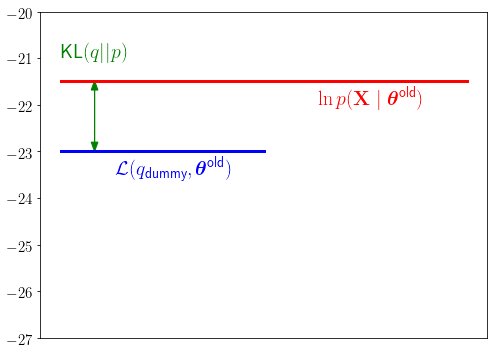

In [ ]:
# 제안분포를 dummy_q()로 선택하여 ELBO를 계산
l_q_theta_dummy = ELBO(dummy_q, theta_old)
ln_p_X_theta = loglikelihood_X(theta_old, X)
print("l(q,theta)    : {:.6f}".format(l_q_theta_dummy))
print("ln p(X|theta) : {:.6f}".format(ln_p_X_theta))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
margin = 0.5

# ln p(X|theta_old)
ax.plot([0, 6], [ln_p_X_theta]*2, 'r', lw='3')
ax.text(3.8, ln_p_X_theta-margin, 
        r"$\ln p( \mathbf{X} \mid \boldsymbol{\theta}^{\text{old}})$",  
        color='r', fontsize=20)

# L(q_dummy,theta_old)
ax.plot([0, 3], [l_q_theta_dummy]*2, 'b', lw='3')
ax.text(0.8, l_q_theta_dummy-margin, 
        r"$\mathcal{L}(q_{\text{dummy}}, \boldsymbol{\theta}^{\text{old}})$", 
        color='b', fontsize=20)

# KL
ax.text(0, ln_p_X_theta+margin, r"$\text{KL}(q || p)$",  color='g', fontsize=20)
ax.arrow(0.5, l_q_theta_dummy, 0, ln_p_X_theta-l_q_theta_dummy, 
         head_width=0.1, head_length=0.2, fc='g', ec='g', length_includes_head=True)
ax.arrow(0.5, ln_p_X_theta, 0, l_q_theta_dummy-ln_p_X_theta, 
         head_width=0.1, head_length=0.2, fc='g', ec='g', length_includes_head=True)

ax.set_ylim([-27, -20])
plt.xticks([])
plt.yticks(fontsize=15)
plt.show()

현재 파라미터 $\boldsymbol{\theta}^{\text{old}}$에서 `dummy_q()`를 $q(\mathbf{Z})$로 하여 $\mathcal{L}(q, \boldsymbol{\theta}^{\text{old}})$값을 계산해보면 $\ln p(\mathbf{X} \mid \boldsymbol{\theta}^{\text{old}})$ 보다 약간 작고 그 차이가 $\text{KL}(q\,||\,p)$로 나타나는 것을 확인할 수 있다. 


이제 $q(\mathbf{Z})$를 $\mathbf{Z}$에 대한 사후확률분포로 바꿔보자. $q(\mathbf{Z}) = p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}})$로 설정한다.

l(q,theta)    : -21.484619
ln p(X|theta) : -21.484619


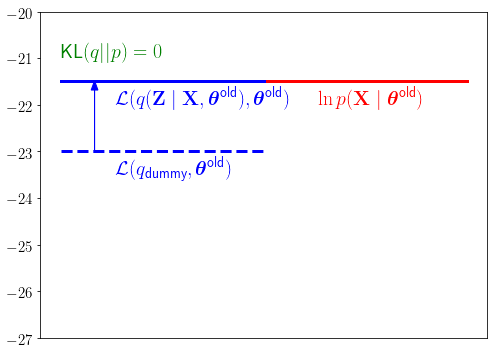

In [ ]:
# ELBO를 계산할 때 제안하는 q(Z)를 Z의 사후확률분포로 제안한다.
p_Z_given_X_and_theta_old = set_posterior_Z(X, theta_old)

l_q_theta = ELBO(p_Z_given_X_and_theta_old, theta_old)
ln_p_X_theta = loglikelihood_X(theta_old, X)
print("l(q,theta)    : {:.6f}".format(l_q_theta))
print("ln p(X|theta) : {:.6f}".format(ln_p_X_theta))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

# ln p(X|theta_old)
ax.plot([0, 6], [ln_p_X_theta]*2, 'r', lw='3')
ax.text(3.8, ln_p_X_theta-margin, r"$\ln p( \mathbf{X} \mid \boldsymbol{\theta}^{\text{old}})$",  
        color='r', fontsize=20)

# L(q(Z|X, theta_old),theta_old)
ax.plot([0, 3], [l_q_theta]*2, 'b', lw='3')
ax.text(0.8, l_q_theta-margin, r"$\mathcal{L}(q(\mathbf{Z}\mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}}), \boldsymbol{\theta}^{\text{old}})$", 
        color='b', fontsize=20)
ax.arrow(0.5, l_q_theta_dummy, 0, ln_p_X_theta-l_q_theta_dummy, 
         head_width=0.1, head_length=0.2, fc='b', ec='b', length_includes_head=True)


# L(q_dummy,theta_old)
ax.plot([0, 3], [l_q_theta_dummy]*2, 'b--', lw='3')
ax.text(0.8, l_q_theta_dummy-margin, r"$\mathcal{L}(q_{\text{dummy}}, \boldsymbol{\theta}^{\text{old}})$", 
        color='b', fontsize=20)

# KL
ax.text(0, ln_p_X_theta+margin, r"$\text{KL}(q || p)=0$",  color='g', fontsize=20)

ax.set_ylim([-27, -20])
plt.xticks([])
plt.yticks(fontsize=15)
plt.show()

예상대로 $\mathcal{L}(q, \boldsymbol{\theta}^{\text{old}})= \ln p(\mathbf{X} \mid \boldsymbol{\theta}^{\text{old}})$가 되며 $\text{KL}(q\,||\,p)$가 사라진다.

### $\mathcal{L}(q, \boldsymbol{\theta})$와 완전 데이터 세트 로그가능도 평균 $\mathbb{E}_{\mathbf{Z}}[\ln  p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})]$의 관계




이쯤에서 지금까지 이야기한 완전 데이트 세트에 대한 로그 가능도 평균과 그것을 반복적으로 최대화 시키는 과정이 식(9.70)과 어떻게 연결되는지 알아보자. 

$q(\mathbf{Z})$를 $p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}})$로 설정하면 $\mathcal{L}(q, \boldsymbol{\theta})$는 식(9.74)처럼 될 것이다.

$$
\begin{aligned}
\mathcal{L}(q, \boldsymbol{\theta})
&= \sum_{\mathbf{Z}} p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}}) \ln p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta}) - \sum_{\mathbf{Z}} p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}}) \ln p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}}) \\
&=  \mathcal{Q}(\boldsymbol{\theta}, \boldsymbol{\theta}^{\text{old}}) + \text{const} 
\end{aligned} \tag{9.74}
$$


놀랍게도 식(9.74)에서 첫 번째 항은 $\mathcal{Q}(\boldsymbol{\theta}, \boldsymbol{\theta}^{\text{old}})$ 또는 $\mathbb{E}_{\mathbf{Z}}[\ln(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})]$가 된다. 그리고 두 번째 항은 현재 파라미터 $\boldsymbol{\theta}^{\text{old}}$에만 의존하고 $\boldsymbol{\theta}$와는 상관없는 상수항이다. 따라서 $q(\mathbf{Z})$를 $\mathbf{Z}$의 사후확률분포로 설정하고 $\mathcal{L}(q, \boldsymbol{\theta})$을 계산하는 것이 결국 $\mathbf{Z}$의 사후확률분포하에서 완전 데이터 세트의 로그가능도 평균을 구하는 것과 대등한 것이다.

결국 $\mathcal{Q}(\boldsymbol{\theta}, \boldsymbol{\theta}^{\text{old}})$ 또는 $\mathbb{E}_{\mathbf{Z}}[\ln(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})]$를 $\boldsymbol{\theta}$대해 최대화 하는 것이 $\mathcal{L}(q, \boldsymbol{\theta})$를 최대화 하는 것이라는 사실을 알 수 있다.

방금까지 과정이 EM 알고리즘에서 기대값을 구성하는 단계인 Expectation 단계이다.

 정리하면 우리는 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 최대화 하는 $\boldsymbol{\theta}$를 찾고 싶은데 $\ln(\mathbf{X} \mid \boldsymbol{\theta})$를 직접 최대화하는 것은 어려우니 $\mathbf{Z}$의 사후확률을 도입하여 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$의 하한인 $\mathcal{L}(q, \boldsymbol{\theta})$를 최대한 키워 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$와 동일하게 만들었다.  
 
 그리고 이때 $\mathcal{L}(q, \boldsymbol{\theta})$는 완전 데이터 세트에 대한 가능도의 기댓값 $\mathbb{E}_{\mathbf{Z}}[\ln (\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})]$와 상수로 구성되기 때문에 결과적으로 $\mathcal{L}(q, \boldsymbol{\theta})$를 최대화 시키는 것이 곧 $\mathbb{E}_{\mathbf{Z}}[\ln (\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})]$를 최대화 시키는 것을 알았다. 또 중요한 점은 $\mathcal{L}(q, \boldsymbol{\theta})$이 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$의 하한이기 때문에 $\mathcal{L}(q, \boldsymbol{\theta})$을 증가시키면 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$는 무조건 증가할 것이라는 점이다. 

$\mathbb{E}_{\mathbf{Z}}[\ln (\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})]$를 최대화 시키는 것은 이미 3편에서 알아본 것과 같다. $\gamma$를 구해 Expectation 단계를 수행한다. $\gamma$를 구하는 과정이 곧 $p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}})$를 제안하는 것임을 상기하자. 그렇게 제안된 $p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}})$하에서 계산된 $\mathbb{E}_{\mathbf{Z}}[\ln (\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})]$를 직접 미분하여 얻은 식(29), (32)를 수행한다.

이 두 과정을 묶어 `EM_step()`이라는 함수로 만들자.

In [ ]:
def EM_step() :
    """
    gloval variables
    X : (N,D)
    theta_old : (4,), (mu_1, mu_2, pi_1, pi_2)
    n_t
    """
    mu_old = theta_old[:K*D].reshape(K,D)
    pi_old = theta_old[-K:]

    Gamma = np.array([ pi_old[k]*binom.pmf(X, n_t, mu_old[k][0]) 
                        for k in range(K) ]).transpose(1,0,2).squeeze()
    Gamma /= Gamma.sum(axis=1, keepdims=True)

    Nk = Gamma.sum(axis=0)
    mu_new = ((Gamma * X).sum(axis=0) / (Nk*n_t)).reshape(-1,1)
    pi_new = Nk / N

    return mu_new, pi_new

실제 `EM_step()`을 수행하고 새롭게 얻어진 파라미터를 `theta_new`로 설정한다.

In [ ]:
mu_new, pi_new = EM_step()
theta_new = np.hstack((mu_new.flatten(), pi_new))

print(theta_old)
print(theta_new)

[0.4 0.3 0.5 0.5]
[0.70729725 0.45725284 0.73085881 0.26914119]


새롭게 계산된 파라미터 $\boldsymbol{\theta}^{\text{new}}$에 의해 증가된 $\mathcal{L}(q, \boldsymbol{\theta})$와 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 그려보자.

l(q,theta)    : -13.141270
ln p(X|theta) : -21.484619


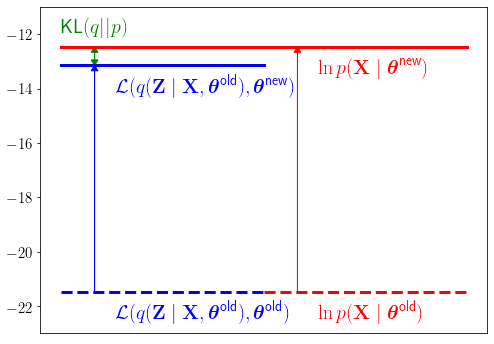

In [ ]:
# ELBO를 계산할 때 제안하는 q(Z)를 Z의 사후확률분포로 제안한다.
# theta_old가 theta_new로 업데이트 되었으나 사후분포를 구성할 때 사용된
# theta_old는 고정된 상태이다.
p_Z_given_X_and_theta_old = set_posterior_Z(X, theta_old)

l_q_theta_new = ELBO(p_Z_given_X_and_theta_old, theta_new)
ln_p_X_theta_new = loglikelihood_X(theta_new, X)
print("l(q,theta)    : {:.6f}".format(l_q_theta_new))
print("ln p(X|theta) : {:.6f}".format(ln_p_X_theta))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

# ln p(X|theta_new)
ax.plot([0, 6], [ln_p_X_theta_new]*2, 'r', lw='3')
ax.text(3.8, ln_p_X_theta_new-margin*2, r"$\ln p( \mathbf{X} \mid \boldsymbol{\theta}^{\text{new}})$",  
        color='r', fontsize=20)
ax.arrow(3.5, ln_p_X_theta, 0, ln_p_X_theta_new-ln_p_X_theta, 
         head_width=0.1, head_length=0.2, fc='r', ec='r', length_includes_head=True)

# ln p(X|theta_old)
ax.plot([3, 6], [ln_p_X_theta]*2, 'r--', lw='3')
ax.text(3.8, ln_p_X_theta-margin*2, r"$\ln p( \mathbf{X} \mid \boldsymbol{\theta}^{\text{old}})$",  
        color='r', fontsize=20)

# L(q(Z|X, theta_old),theta_new)
ax.plot([0, 3], [l_q_theta_new]*2, 'b', lw='3')
ax.text(0.8, l_q_theta_new-margin*2, r"$\mathcal{L}(q(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}}), \boldsymbol{\theta}^{\text{new}})$", 
        color='b', fontsize=20)
ax.arrow(0.5, l_q_theta, 0, l_q_theta_new-l_q_theta, 
         head_width=0.1, head_length=0.2, fc='b', ec='b', length_includes_head=True)

# L(q(Z|X, theta_old),theta_old)
ax.plot([0, 3], [l_q_theta]*2, 'b--', lw='3')
ax.text(0.8, l_q_theta-margin*2, r"$\mathcal{L}(q(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}}), \boldsymbol{\theta}^{\text{old}})$", 
        color='b', fontsize=20)

# KL
ax.text(0, ln_p_X_theta_new+margin, r"$\text{KL}(q || p)$",  color='g', fontsize=20)
ax.arrow(0.5, l_q_theta_new, 0, ln_p_X_theta_new-l_q_theta_new, 
         head_width=0.1, head_length=0.2, fc='g', ec='g', length_includes_head=True)
ax.arrow(0.5, ln_p_X_theta_new, 0, l_q_theta_new-ln_p_X_theta_new, 
         head_width=0.1, head_length=0.2, fc='g', ec='g', length_includes_head=True)

ax.set_ylim([-23, -11])
plt.xticks([])
plt.yticks(fontsize=15)
plt.show()

$\boldsymbol{\theta}^{\text{old}}$에서 $\boldsymbol{\theta}^{\text{new}}$로 파라미터가 조정되면서 두 함수 모두 점선 위치에서 증가하였다. 증가된 정도를 보면 $\ln p(\mathbf{X} \mid  \boldsymbol{\theta}^{\text{new}})$가 $\mathcal{L}(q, \boldsymbol{\theta}^{\text{new}})$보다 조금 더 증가되었다. 그 이유는 $\boldsymbol{\theta}^{\text{old}}$에서 $\boldsymbol{\theta}^{\text{new}}$ 변경되면서 현재 파라미터 상태에서 $p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{new}})$는 $p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{old}})$와 달라졌으며 그 결과 $KL(q \,||\, p)$는 다음과 같이 0이 아니기 때문이다.


$$
KL(q \,||\, p) = - \sum_{\mathbf{Z}} p(\mathbf{Z} \mid \mathbf{X},\boldsymbol{\theta}^{\text{old}}) \ln \frac{p(\mathbf{Z} \mid \mathbf{X},\boldsymbol{\theta}^{\text{new}})}{ p(\mathbf{Z} \mid \mathbf{X},\boldsymbol{\theta}^{\text{old}}) } \neq 0
$$

이 한번의 반복으로 원래 $\boldsymbol{\theta}^{\text{old}}$보다 더 큰 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$ 함숫값을 주는 $\boldsymbol{\theta}^{\text{new}}$를 찾아내게 되었다. 이 과정이 Maximization 과정이다.

이제 $q(\mathbf{Z})$를 $p(\mathbf{Z} \mid \mathbf{X}, \boldsymbol{\theta}^{\text{new}})$로 재설정하는 Expectation 과정을 반복하면 두 번째 그림 상태로 돌아가게 된다. 여기서 다시 Maximization 과정을 수행하여 조금 더 큰 $\ln p(\mathbf{X} \mid  \boldsymbol{\theta})$ 함숫값을 주는 $\boldsymbol{\theta}^{\text{new}}$를 구할 수 있다. 이 과정을 반복하는 동안 $\ln p(\mathbf{X} \mid  \boldsymbol{\theta})$는 절대 줄어들지 않으며 결과적으로 $\mathbb{E}_{\mathbf{Z}}[\ln (\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\theta})]$를 최대화하는 과정을 반복하면서 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 최대화하게 되는 것이다.

이것으로 평균을 최대화 시키는 방법이 왜 유효하고 그것의 반복이 왜 수렴하는지 알 수 있게 되었다.

## EM 알고리즘 시각화

지금까지 아주 길게 완전 데이트 세트 가능도 평균의 최대화를 반복하는 과정이 $\ln(\mathbf{X} \mid \boldsymbol{\theta})$를 최대화시키는 이유에 대해서 알아보았다. 이제 실제 우리가 설정한 문제에서 어떤 식으로 최대화가 일어나고 있는지 시각화하면서 이 길고 지루한 과정을 마무리해보자.

우리가 다루고 있는 문제에서 구하고자 하는 파라미터는 총 4개이므로 이 모든 파라미터가 최적화되는 과정을 시각화 할 수 없다. 그러므로 $\boldsymbol{\theta}$에서 $\mu_1$에 대해서만 $\mathcal{L}(q, \boldsymbol{\theta})$와 $\ln p(\mathbf{X} \mid  \boldsymbol{\theta})$의 관계를 시각화 해보자.

현재 파라미터 상태를 적당히 설정한다.

In [ ]:
mu_old = np.array([[0.6],[0.45]])
pi_old = np.array([0.6, 0.4])
theta_old = np.hstack((mu_old.flatten(), pi_old))

이전에 만들어 놓은 `loglikelihood_X()`를 이용해서 $\mu_1$만을 변수로 하는 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 만든다.

In [ ]:
def loglikelihood_X_mu1(mu_1, X):
    return loglikelihood_X(np.array([mu_1, 0.45, 0.6, 0.4]), X)

이제 $\mu_1$에 따른 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$를 그려본다. 우리 목적은 국부적으로 $\ln p(\mathbf{X} \mid \boldsymbol{\theta})$가 가장 높은 곳을 찾아가는 것이다.

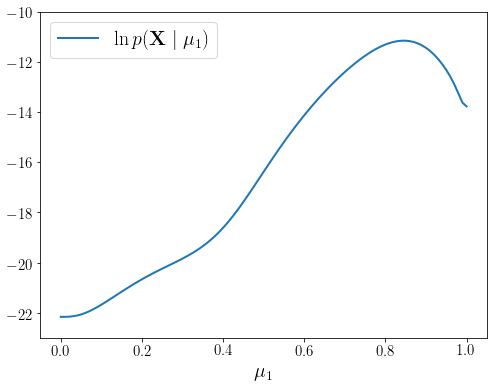

In [ ]:
mus = np.linspace(0, 1, 100)

# ln( p(X|theta) )
loglikelihood_X_by_mu1 = np.array([ loglikelihood_X_mu1(mu,  X) 
                                    for mu in mus ])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(mus, loglikelihood_X_by_mu1, lw=2, 
        label=r"$\ln p(\mathbf{X} \mid \mu_1)$")
ax.set_ylim([-23, -10])
plt.legend(fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\mu_1$', fontsize=20)

plt.show()

그림을 보면 0.8x 정도에서 최대점이 형성되는 것을 알 수 있다.


완전 데이터 집합의 로그가능도 평균도 $\mu_1$만의 함수로 다시 만든다.

In [ ]:
def E_Z_loglikelihood_XZ_mu1(mu_1, X):
    # mu_1을 제외한 나머지 파라미터들은 이미 최적화된 것으로 가정하고 고정
    return E_Z_loglikelihood_XZ(np.array([mu_1, 0.45, 0.6, 0.4]), X)

이제 현재 $\boldsymbol{\theta}^{\text{old}}$를 조건으로 하는 사후확률분포를 이용하여 전체 $\mu_1$에 대해서 $\mathcal{L}(q, \mu_1)$을 그려본다. 이때 $\ln p(\mathbf{X} \mid \mu_1)$도 함께 그려 상황을 확인해보자. 

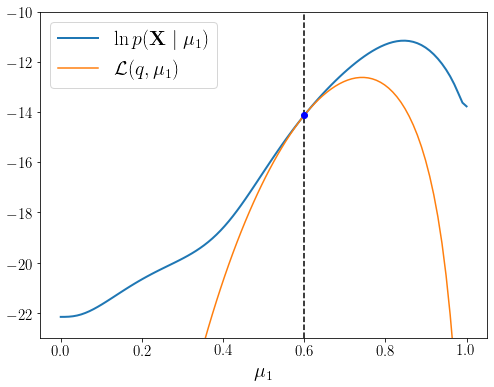

In [ ]:
mus = np.linspace(0, 1, 100)

# 현재 파라미터로 Z의 사후확률 q(Z|X,mu_1^{old})를 세팅한다.
p_Z_given_X_and_theta_old = set_posterior_Z(X, theta_old)

# L(q,mu_1)를 mu_1에 대해서 다시 그린다.
l_q_theta = np.array([ E_Z_loglikelihood_XZ_mu1(mu, X) 
                        - entropy_Z(p_Z_given_X_and_theta_old) for mu in mus ])

# 현재 \mu_1^{old}에서 L(q,mu_1) 값을 계산한다.
l_q_theta_0 = E_Z_loglikelihood_XZ_mu1(mu_old[0,0], X) \
                - entropy_Z(p_Z_given_X_and_theta_old) 

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(mus, loglikelihood_X_by_mu1, lw=2, 
        label=r"$\ln p(\mathbf{X} \mid \mu_1)$")
ax.plot(mus, l_q_theta, label=r"$\mathcal{L}(q, \mu_1)$")
ax.plot([mu_old[0,0], mu_old[0,0]], [-23,-10], 'k--')
ax.plot(mu_old[0,0], l_q_theta_0, 'bo')
ax.set_ylim([-23, -10])
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\mu_1$', fontsize=20)
plt.show()

그림에서 확인할 수 있듯이 현재 파리미터에서 $\mathcal{L}(q, \mu_1^{\text{old}}=0.6)$과 $\ln p(\mathbf{X} \mid \mu^{\text{old}}_1=0.6)$가 같아지는 모습을 확인할 수 있다. 이제 이 상태에서 EM 스탭을 한번 반복한다. 

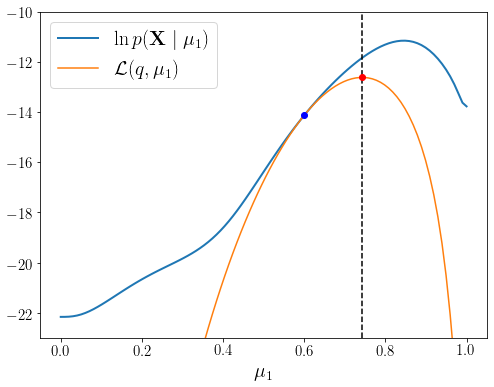

In [ ]:
# EM_step으로 새로운 파라미터를 얻는다.
mu_new, pi_new = EM_step()

# 업데이트된 mu_1^{new}에서 L(q,mu_1) 값을 계산한다.
max_l_q_theta = E_Z_loglikelihood_XZ_mu1(mu_new[0,0], X) \
                - entropy_Z(p_Z_given_X_and_theta_old) 

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(mus, loglikelihood_X_by_mu1, lw=2, 
        label=r"$\ln p(\mathbf{X} \mid \mu_1)$")
ax.plot(mus, l_q_theta, label=r"$\mathcal{L}(q, \mu_1)$")
ax.plot([mu_new[0,0], mu_new[0,0]], [-23,-10], 'k--')
ax.plot(mu_new[0,0], max_l_q_theta, 'ro')
ax.plot(mu_old[0,0], l_q_theta_0, 'bo')
ax.set_ylim([-23, -10])
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\mu_1$', fontsize=20)
plt.show()

`EM_step()` 결과 $\mu_1^{\text{old}}$가 $\mathcal{L}(q, \mu_1)$의 최대점으로 이동한 것을 확인할 수 있다. 파란 점보다 빨간 점이 $\ln p(\mathbf{X} \mid \mu_1)$의 최대점에 조금 더 가까워졌다. 새롭게 구해진 파라미터를 $\boldsymbol{\theta}^{\text{old}}$로 업데이트하고 $\boldsymbol{\theta}^{\text{old}}$를 조건으로 다시 $\mathbf{Z}$의 사후확률분포를 계산한다.

In [ ]:
mu_old = mu_new
pi_old = pi_new
theta_old = np.hstack((mu_old.flatten(), pi_old))

# 현재 파라미터로 Z의 사후확률을 세팅한다.
p_Z_given_X_and_theta_old = set_posterior_Z(X, theta_old)

print(mu_old)
print(pi_old)

[[0.7428154 ]
 [0.43070022]]
[0.67058506 0.32941494]


새롭게 구성된 사후확률하에서 $\mathcal{L}(q, \mu_1)$을 다시 그려보면 $\mu_1^{\text{old}}=0.743$에서 $\ln p(\mathbf{X} \mid \mu_1)$과 접할 것이다.

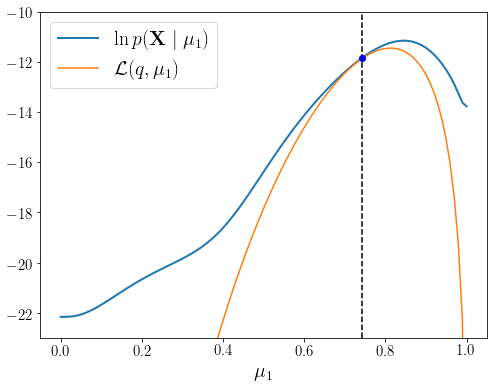

In [ ]:
l_q_theta = np.array([ E_Z_loglikelihood_XZ_mu1(mu, X) 
                       - entropy_Z(p_Z_given_X_and_theta_old) for mu in mus ])

l_q_theta_0 = E_Z_loglikelihood_XZ_mu1(mu_old[0,0], X) \
                - entropy_Z(p_Z_given_X_and_theta_old) 

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(mus, loglikelihood_X_by_mu1, lw=2, 
        label=r"$\ln p(\mathbf{X} \mid \mu_1)$")
ax.plot(mus, l_q_theta, label=r"$\mathcal{L}(q, \mu_1)$")
ax.plot([mu_old[0,0], mu_old[0,0]], [-23,-10], 'k--')
ax.plot(mu_old[0,0], l_q_theta_0, 'bo')
ax.set_ylim([-23, -10])
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\mu_1$', fontsize=20)
plt.show()

예상대로 새롭게 구성된 $\mathcal{L}(q, \mu_1)$이 $\mu_1=0.743$에서 접하는 것을 확인할 수 있다. 이제 다시 `EM_step()`를 실행한다.

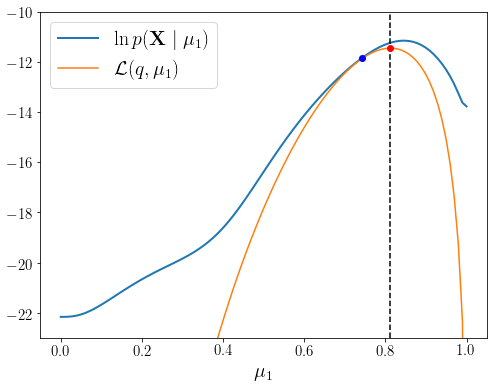

In [ ]:
mu_new, pi_new = EM_step()
max_l_q_theta = E_Z_loglikelihood_XZ_mu1(mu_new[0,0], X) \
                  - entropy_Z(p_Z_given_X_and_theta_old)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(mus, loglikelihood_X_by_mu1, lw=2, 
        label=r"$\ln p(\mathbf{X} \mid \mu_1)$")
ax.plot(mus, l_q_theta, label=r"$\mathcal{L}(q, \mu_1)$")
ax.plot([mu_new[0,0], mu_new[0,0]], [-23,-10], 'k--')
ax.plot(mu_new[0,0], max_l_q_theta, 'ro')
ax.plot(mu_old[0,0], l_q_theta_0, 'bo')
ax.set_ylim([-23, -10])
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\mu_1$', fontsize=20)
plt.show()

다시 $\mathcal{L}(q, \mu_1)$의 최대값으로 파라미터가 업데이트 된다. 이런 과정을 계속 반복하면서 $\ln p(\mathbf{X} \mid \mu_1)$의 국부 최대점으로 수렴하게 되는 것이다.

In [ ]:
mu_old = mu_new
pi_old = pi_new
theta_old = np.hstack((mu_old.flatten(), pi_old))

# 현재 파라미터로 Z의 사후확률을 세팅한다.
p_Z_given_X_and_theta_old = set_posterior_Z(X, theta_old)

print(mu_old)
print(pi_old)

[[0.81242457]
 [0.37383545]]
[0.60686538 0.39313462]


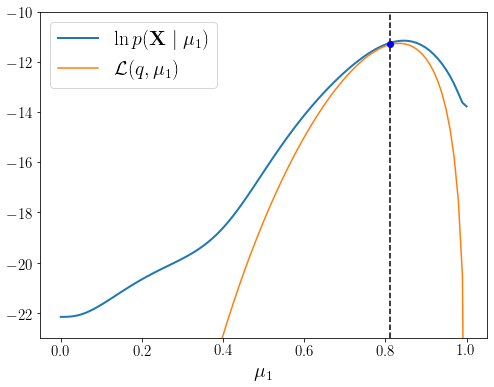

In [ ]:
l_q_theta = np.array([ E_Z_loglikelihood_XZ_mu1(mu, X) 
                       - entropy_Z(p_Z_given_X_and_theta_old) for mu in mus ])

l_q_theta_0 = E_Z_loglikelihood_XZ_mu1(mu_old[0,0], X) \
                - entropy_Z(p_Z_given_X_and_theta_old) 

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(mus, loglikelihood_X_by_mu1, lw=2, 
        label=r"$\ln p(\mathbf{X} \mid \mu_1)$")
ax.plot(mus, l_q_theta, label=r"$\mathcal{L}(q, \mu_1)$")
ax.plot([mu_old[0,0], mu_old[0,0]], [-23,-10], 'k--')
ax.plot(mu_old[0,0], l_q_theta_0, 'bo')
ax.set_ylim([-23, -10])
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\mu_1$', fontsize=20)
plt.show()

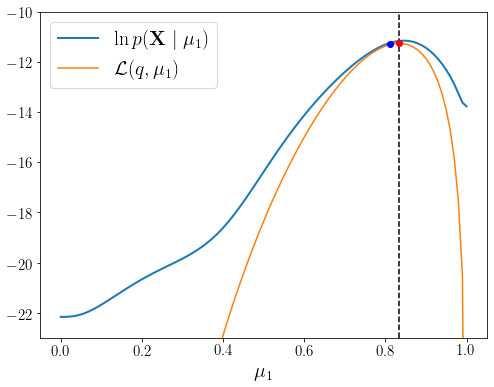

In [ ]:
mu_new, pi_new = EM_step()
max_l_q_theta = E_Z_loglikelihood_XZ_mu1(mu_new[0,0], X) \
                  - entropy_Z(p_Z_given_X_and_theta_old) 

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(mus, loglikelihood_X_by_mu1, lw=2, 
        label=r"$\ln p(\mathbf{X} \mid \mu_1)$")
ax.plot(mus, l_q_theta, label=r"$\mathcal{L}(q, \mu_1)$")
ax.plot([mu_new[0,0], mu_new[0,0]], [-23,-10], 'k--')
ax.plot(mu_new[0,0], max_l_q_theta, 'ro')
ax.plot(mu_old[0,0], l_q_theta_0, 'bo')
ax.set_ylim([-23, -10])
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\mu_1$', fontsize=20)
plt.show()

이렇게 나름 복잡하다면 복잡한 EM 알고리즘을 알아봤다. 소설처럼 술술 읽히는 글은 아닐지라도 EM 알고리즘을 어렴풋이 이해하고 있는 분들께는 나름 도움이 될 것이라는 믿음으로 글을 마무리한다. 